# CNN + GlobalAvgPool
Run this model on all lncRNA cell lines using some theshold. This notebook tests RCI GMM(2).

* zero
* RCI threshold set by GMM(2).
* Antilog threshold set by GMM(2).

Rerun CNN_169 with pretty pictures.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-02-06 14:09:01.569466
Python 3.8.10
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'
CACHING = False   # have not worked out how to cache multiple cell lines

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1,7]   # use these though they are clearly different

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line]
                    if rci_str != "nan":
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-02-06 14:09:34.862246
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        
    def set_sequences(self, allids, allseq):
        # It is critical to keep IDs and sequences in same order!
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order!
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def get_X_y(self, gene_index):
        cnt = len(self.all_ids)
        subsetX=[]
        subsetY=[]
        next_index = 0
        for i in range(cnt):
            if next_index==len(gene_index):
                break
            if i==gene_index[next_index]:
                gene_id,tran_id = self.all_ids[i]
                oneX = self.all_seqs[i]
                oneY = self.rci_map[gene_id]
                subsetX.append(oneX)
                subsetY.append(oneY)
                next_index += 1
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def rcis_to_labels(self, array_of_rci, rci_threshold):
        IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
        return np.array(list(map(IS_CYTO, array_of_rci)))
    
    def choose_rci_threshold(self, rci_values):
        discrim = 0
        if RCI_THRESHOLD_MECHANISM == 'RCI_GMM':
            gmm2 = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=10) # best of 10
            gmm2.fit(rci_values)
            # Optimal discriminator = weighted average of means of the 2 gaussians
            discrim = gmm2.weights_[0]*gmm2.means_[0]+gmm2.weights_[1]*gmm2.means_[1]
            print('Model params (mean %.2f, wgt %.2f) (mean %.2f, wgt %.2f)' %
                (gmm2.means_[0], gmm2.weights_[0], gmm2.means_[1], gmm2.weights_[1]))
        return discrim
        
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        cv_auprc=[]
        cv_auroc=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            X_train,y_train = self.get_X_y(train_index)
            train_based_rci_threshold = self.choose_rci_threshold(y_train)
            y_train = self.rcis_to_labels(y_train,train_based_rci_threshold)
            X_valid,y_valid = self.get_X_y(valid_index)
            y_valid = self.rcis_to_labels(y_valid,train_based_rci_threshold) # yes, train_based
            print('RCI threshold derived from training set:',train_based_rci_threshold)

            #print('Training example')
            #print(X_train[0])
            #print("BUILD MODEL")
            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            # PRC
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print('Train set ones/size',
                      np.count_nonzero(y_train),'/',len(y_train))
                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Valid set ones/size',
                      np.count_nonzero(y_valid),'/',len(y_valid))
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)
                print('Prediction set ones/size',
                      np.count_nonzero(yhat_classes),'/',len(yhat_classes))
            
                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()
            
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% AUPRC: %.2f%% AUROC: %.2f%%' % (f1,auprc,auroc)) 
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_auprc.append(auprc)
            cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc

2023-02-06 14:09:37.641675
Start cell Line 0 A549
Number of RCI values loaded 1447
Num RCI: 1447
Load sequence...
Cross validation...
2023-02-06 14:09:52.477061
splitting
Fold 1
Model params (mean -0.98, wgt 0.43) (mean 0.58, wgt 0.57)
RCI threshold derived from training set: [-0.08389576]
FIT
2023-02-06 14:09:55.211871
Epoch 1/3
218/218 [==============================] - 10s 12ms/step - loss: 0.6868 - accuracy: 0.5450 - val_loss: 0.6611 - val_accuracy: 0.6001
Epoch 2/3
218/218 [==============================] - 2s 11ms/step - loss: 0.6200 - accuracy: 0.6546 - val_loss: 0.6182 - val_accuracy: 0.6530
Epoch 3/3
218/218 [==============================] - 2s 11ms/step - loss: 0.5341 - accuracy: 0.7266 - val_loss: 0.5829 - val_accuracy: 0.6824
PREDICT
2023-02-06 14:10:10.485722


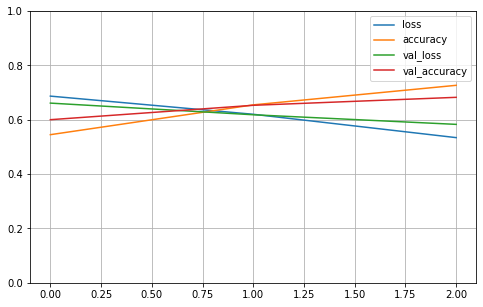

Train set ones/size 3716 / 6949
Compute valiation accuracy
Valid sizes (1738, 4997) (1738,)
Valid set ones/size 945 / 1738
Range of scores: 0.009077073 to 0.96928084
Score threshold 0.5
Prediction set ones/size 633 / 1738


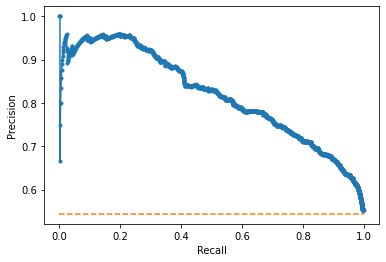

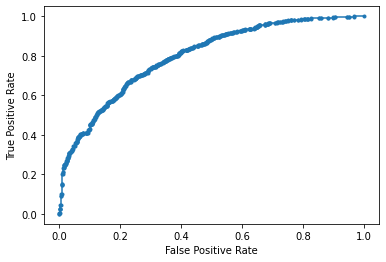

Accuracy: 68.24% Precision: 81.04% Recall: 54.29%
F1: 65.02% AUPRC: 81.94% AUROC: 79.83%
2023-02-06 14:10:11.261291
Fold 2
Model params (mean 0.57, wgt 0.57) (mean -0.95, wgt 0.43)
RCI threshold derived from training set: [-0.07343204]
FIT
2023-02-06 14:10:15.418557
Epoch 1/3
218/218 [==============================] - 3s 12ms/step - loss: 0.6983 - accuracy: 0.5368 - val_loss: 0.6821 - val_accuracy: 0.5662
Epoch 2/3
218/218 [==============================] - 2s 11ms/step - loss: 0.6350 - accuracy: 0.6387 - val_loss: 0.5880 - val_accuracy: 0.6761
Epoch 3/3
218/218 [==============================] - 2s 11ms/step - loss: 0.5272 - accuracy: 0.7405 - val_loss: 0.5985 - val_accuracy: 0.6772
PREDICT
2023-02-06 14:10:26.329529


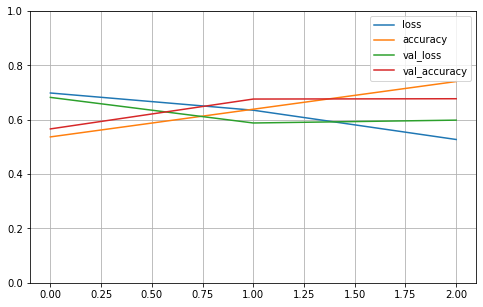

Train set ones/size 3751 / 6949
Compute valiation accuracy
Valid sizes (1738, 4997) (1738,)
Valid set ones/size 901 / 1738
Range of scores: 0.0037494102 to 0.9709132
Score threshold 0.5
Prediction set ones/size 542 / 1738


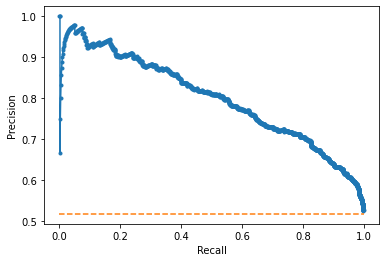

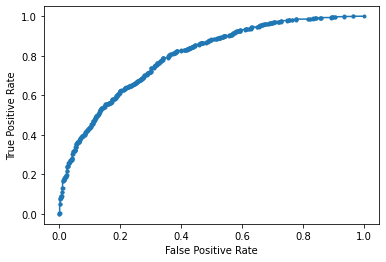

Accuracy: 67.72% Precision: 81.37% Recall: 48.95%
F1: 61.12% AUPRC: 80.00% AUROC: 79.63%
2023-02-06 14:10:27.138246
Fold 3
Model params (mean -0.98, wgt 0.42) (mean 0.58, wgt 0.58)
RCI threshold derived from training set: [-0.08500077]
FIT
2023-02-06 14:10:31.144019
Epoch 1/3
218/218 [==============================] - 3s 13ms/step - loss: 0.6913 - accuracy: 0.5465 - val_loss: 0.6519 - val_accuracy: 0.6223
Epoch 2/3
218/218 [==============================] - 2s 11ms/step - loss: 0.6164 - accuracy: 0.6633 - val_loss: 0.5896 - val_accuracy: 0.6920
Epoch 3/3
218/218 [==============================] - 2s 11ms/step - loss: 0.5273 - accuracy: 0.7417 - val_loss: 0.6116 - val_accuracy: 0.6753
PREDICT
2023-02-06 14:10:39.661683


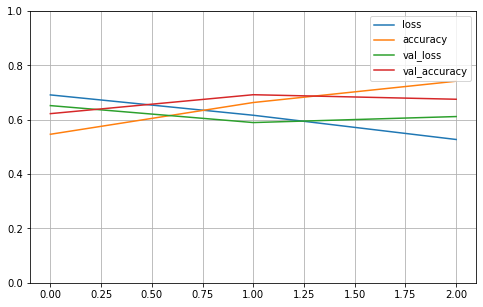

Train set ones/size 3737 / 6950
Compute valiation accuracy
Valid sizes (1737, 4997) (1737,)
Valid set ones/size 932 / 1737
Range of scores: 0.0087289605 to 0.97741586
Score threshold 0.5
Prediction set ones/size 622 / 1737


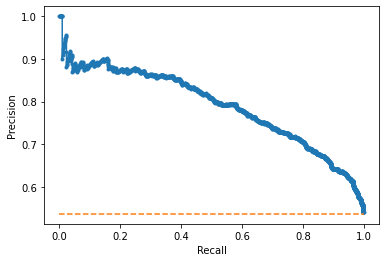

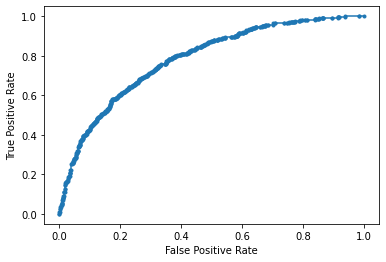

Accuracy: 67.53% Precision: 79.58% Recall: 53.11%
F1: 63.71% AUPRC: 79.09% AUROC: 78.35%
2023-02-06 14:10:40.363433
Fold 4
Model params (mean 0.60, wgt 0.57) (mean -0.96, wgt 0.43)
RCI threshold derived from training set: [-0.06691813]
FIT
2023-02-06 14:10:44.435378
Epoch 1/3
218/218 [==============================] - 3s 12ms/step - loss: 0.6865 - accuracy: 0.5515 - val_loss: 0.6242 - val_accuracy: 0.6713
Epoch 2/3
218/218 [==============================] - 3s 11ms/step - loss: 0.5876 - accuracy: 0.6955 - val_loss: 0.5385 - val_accuracy: 0.7265
Epoch 3/3
218/218 [==============================] - 2s 11ms/step - loss: 0.4915 - accuracy: 0.7652 - val_loss: 0.5175 - val_accuracy: 0.7496
PREDICT
2023-02-06 14:10:55.340171


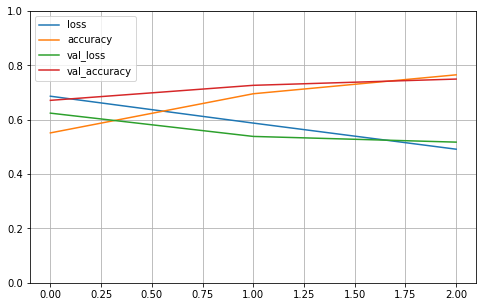

Train set ones/size 3715 / 6950
Compute valiation accuracy
Valid sizes (1737, 4997) (1737,)
Valid set ones/size 936 / 1737
Range of scores: 0.003439408 to 0.9956377
Score threshold 0.5
Prediction set ones/size 909 / 1737


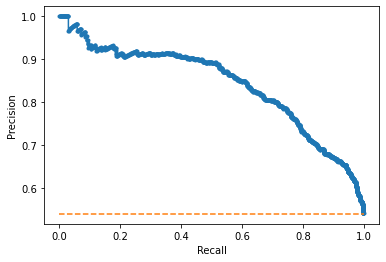

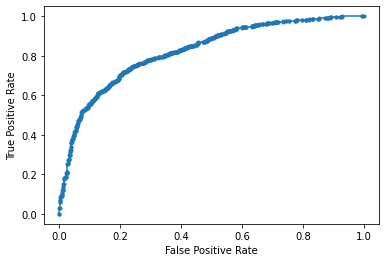

Accuracy: 74.96% Precision: 77.56% Recall: 75.32%
F1: 76.42% AUPRC: 84.14% AUROC: 82.40%
2023-02-06 14:10:56.122936
Fold 5
Model params (mean 0.56, wgt 0.57) (mean -0.93, wgt 0.43)
RCI threshold derived from training set: [-0.08211413]
FIT
2023-02-06 14:11:02.045170
Epoch 1/3
218/218 [==============================] - 3s 13ms/step - loss: 0.6950 - accuracy: 0.5422 - val_loss: 0.6626 - val_accuracy: 0.6062
Epoch 2/3
218/218 [==============================] - 3s 12ms/step - loss: 0.6272 - accuracy: 0.6429 - val_loss: 0.5534 - val_accuracy: 0.7179
Epoch 3/3
218/218 [==============================] - 3s 12ms/step - loss: 0.5241 - accuracy: 0.7377 - val_loss: 0.5095 - val_accuracy: 0.7369
PREDICT
2023-02-06 14:11:10.586361


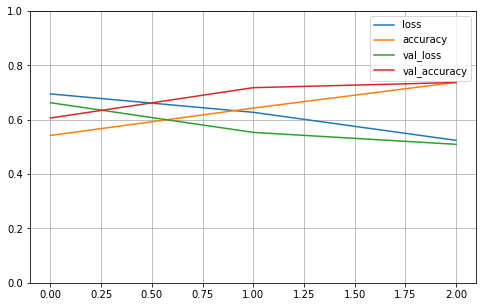

Train set ones/size 3720 / 6950
Compute valiation accuracy
Valid sizes (1737, 4997) (1737,)
Valid set ones/size 941 / 1737
Range of scores: 0.010391762 to 0.9972037
Score threshold 0.5
Prediction set ones/size 1134 / 1737


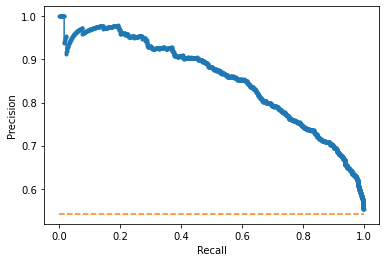

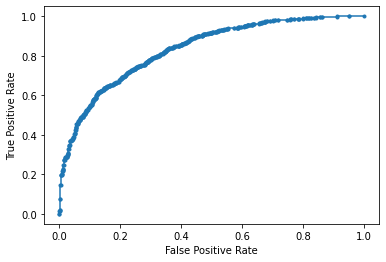

Accuracy: 73.69% Precision: 71.34% Recall: 85.97%
F1: 77.98% AUPRC: 85.34% AUROC: 83.34%
2023-02-06 14:11:11.377184

Completed cross validation 5 folds 3 epochs
 accuracy mean 70.43% +/- 3.21
 precision mean 78.18% +/- 3.67
 recall mean 63.53% +/- 14.49
 F1 mean 68.85% +/- 6.95
 AUPRC mean 82.10% +/- 2.37
 AUROC mean 80.71% +/- 1.86
Finished cell Line 0 A549

2023-02-06 14:11:12.740223
Start cell Line 1 H1.hESC
Number of RCI values loaded 3327
Num RCI: 3327
Load sequence...
Cross validation...
2023-02-06 14:11:34.229320
splitting
Fold 1
Model params (mean -0.93, wgt 0.52) (mean 0.44, wgt 0.48)
RCI threshold derived from training set: [-0.27892325]
FIT
2023-02-06 14:11:39.570428
Epoch 1/3
414/414 [==============================] - 6s 12ms/step - loss: 0.6811 - accuracy: 0.5600 - val_loss: 0.6581 - val_accuracy: 0.6058
Epoch 2/3
414/414 [==============================] - 5s 11ms/step - loss: 0.6168 - accuracy: 0.6618 - val_loss: 0.5996 - val_accuracy: 0.6714
Epoch 3/3
414/414 [==========

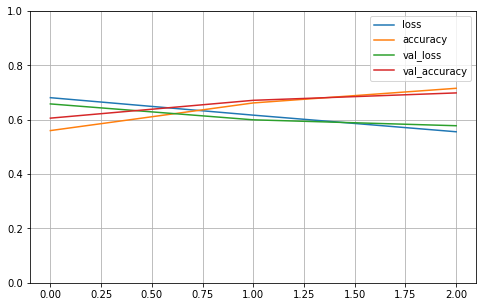

Train set ones/size 6644 / 13228
Compute valiation accuracy
Valid sizes (3308, 4997) (3308,)
Valid set ones/size 1617 / 3308
Range of scores: 0.009946749 to 0.99379796
Score threshold 0.5
Prediction set ones/size 1794 / 3308


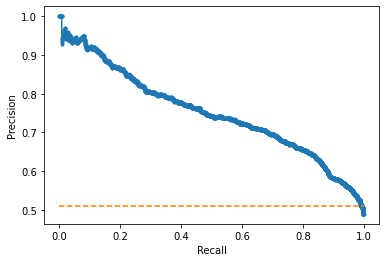

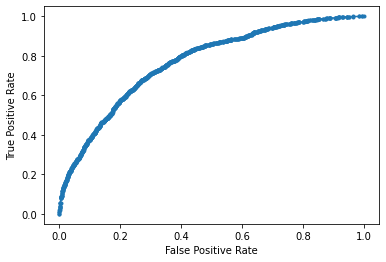

Accuracy: 69.86% Precision: 67.28% Recall: 74.64%
F1: 70.77% AUPRC: 75.17% AUROC: 76.81%
2023-02-06 14:11:55.999078
Fold 2
Model params (mean 0.43, wgt 0.47) (mean -0.92, wgt 0.53)
RCI threshold derived from training set: [-0.28552308]
FIT
2023-02-06 14:12:02.015771
Epoch 1/3
414/414 [==============================] - 6s 12ms/step - loss: 0.6751 - accuracy: 0.5719 - val_loss: 0.6168 - val_accuracy: 0.6559
Epoch 2/3
414/414 [==============================] - 5s 12ms/step - loss: 0.6149 - accuracy: 0.6579 - val_loss: 0.6379 - val_accuracy: 0.6447
Epoch 3/3
414/414 [==============================] - 5s 12ms/step - loss: 0.5596 - accuracy: 0.7115 - val_loss: 0.5779 - val_accuracy: 0.6876
PREDICT
2023-02-06 14:12:17.855561


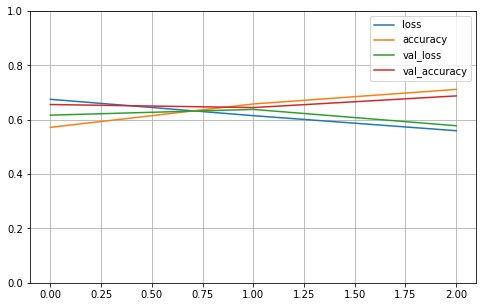

Train set ones/size 6571 / 13229
Compute valiation accuracy
Valid sizes (3307, 4997) (3307,)
Valid set ones/size 1693 / 3307
Range of scores: 0.02123276 to 0.9933617
Score threshold 0.5
Prediction set ones/size 1878 / 3307


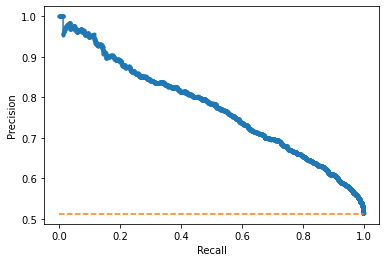

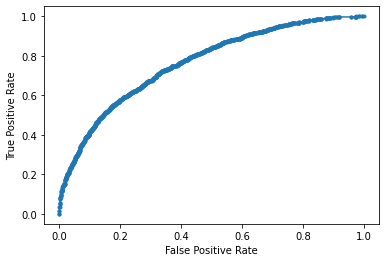

Accuracy: 68.76% Precision: 67.57% Recall: 74.96%
F1: 71.07% AUPRC: 77.37% AUROC: 76.48%
2023-02-06 14:12:18.762926
Fold 3
Model params (mean -0.94, wgt 0.53) (mean 0.43, wgt 0.47)
RCI threshold derived from training set: [-0.2924317]
FIT
2023-02-06 14:12:24.823126
Epoch 1/3
414/414 [==============================] - 6s 13ms/step - loss: 0.6837 - accuracy: 0.5639 - val_loss: 0.6461 - val_accuracy: 0.6172
Epoch 2/3
414/414 [==============================] - 5s 12ms/step - loss: 0.6306 - accuracy: 0.6439 - val_loss: 0.6062 - val_accuracy: 0.6650
Epoch 3/3
414/414 [==============================] - 5s 12ms/step - loss: 0.5818 - accuracy: 0.6929 - val_loss: 0.5932 - val_accuracy: 0.6783
PREDICT
2023-02-06 14:12:46.069521


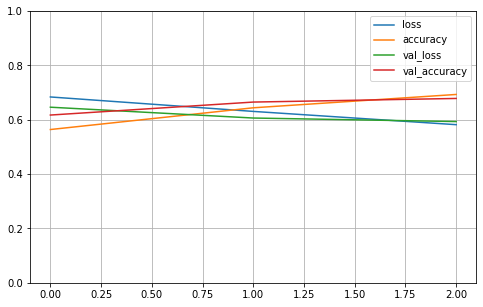

Train set ones/size 6579 / 13229
Compute valiation accuracy
Valid sizes (3307, 4997) (3307,)
Valid set ones/size 1702 / 3307
Range of scores: 0.02046423 to 0.9940579
Score threshold 0.5
Prediction set ones/size 2182 / 3307


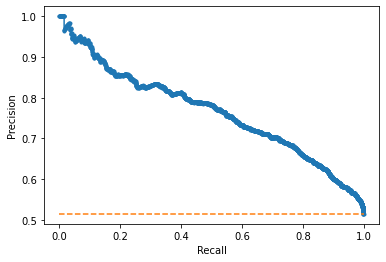

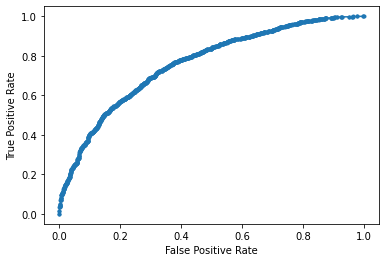

Accuracy: 67.83% Precision: 64.62% Recall: 82.84%
F1: 72.61% AUPRC: 76.60% AUROC: 76.11%
2023-02-06 14:12:47.197351
Fold 4
Model params (mean -0.96, wgt 0.50) (mean 0.40, wgt 0.50)
RCI threshold derived from training set: [-0.27923234]
FIT
2023-02-06 14:12:53.173676
Epoch 1/3
414/414 [==============================] - 6s 13ms/step - loss: 0.6793 - accuracy: 0.5763 - val_loss: 0.6932 - val_accuracy: 0.5815
Epoch 2/3
414/414 [==============================] - 5s 11ms/step - loss: 0.6231 - accuracy: 0.6520 - val_loss: 0.6731 - val_accuracy: 0.5909
Epoch 3/3
414/414 [==============================] - 5s 12ms/step - loss: 0.5736 - accuracy: 0.7035 - val_loss: 0.5582 - val_accuracy: 0.7018
PREDICT
2023-02-06 14:13:14.428375


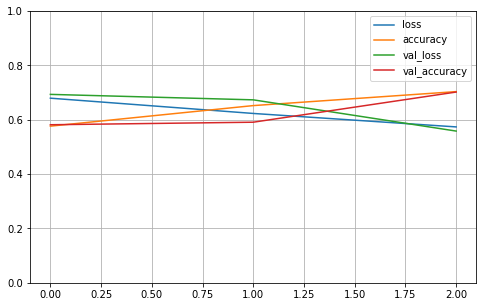

Train set ones/size 6631 / 13229
Compute valiation accuracy
Valid sizes (3307, 4997) (3307,)
Valid set ones/size 1630 / 3307
Range of scores: 0.006742667 to 0.988701
Score threshold 0.5
Prediction set ones/size 1398 / 3307


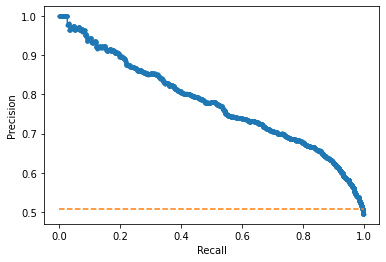

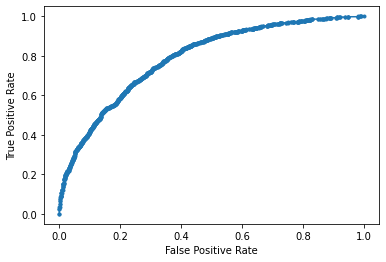

Accuracy: 70.18% Precision: 73.03% Recall: 62.64%
F1: 67.44% AUPRC: 77.86% AUROC: 78.90%
2023-02-06 14:13:15.582061
Fold 5
Model params (mean -0.95, wgt 0.52) (mean 0.43, wgt 0.48)
RCI threshold derived from training set: [-0.28094542]
FIT
2023-02-06 14:13:21.535188
Epoch 1/3
414/414 [==============================] - 6s 12ms/step - loss: 0.6788 - accuracy: 0.5723 - val_loss: 0.6352 - val_accuracy: 0.6365
Epoch 2/3
414/414 [==============================] - 5s 12ms/step - loss: 0.6188 - accuracy: 0.6587 - val_loss: 0.6629 - val_accuracy: 0.6166
Epoch 3/3
414/414 [==============================] - 5s 12ms/step - loss: 0.5628 - accuracy: 0.7143 - val_loss: 0.5774 - val_accuracy: 0.6964
PREDICT
2023-02-06 14:13:37.236025


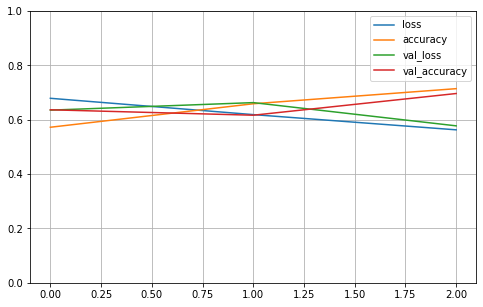

Train set ones/size 6638 / 13229
Compute valiation accuracy
Valid sizes (3307, 4997) (3307,)
Valid set ones/size 1623 / 3307
Range of scores: 0.012196879 to 0.9967734
Score threshold 0.5
Prediction set ones/size 1773 / 3307


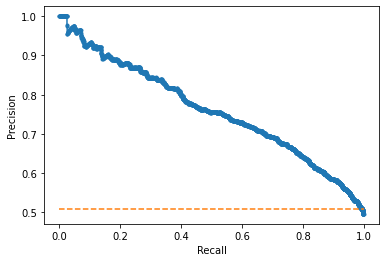

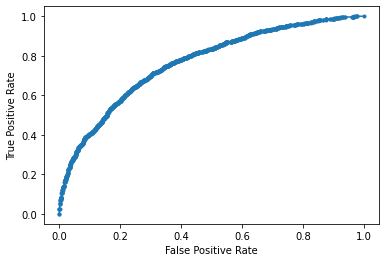

Accuracy: 69.64% Precision: 67.46% Recall: 73.69%
F1: 70.44% AUPRC: 76.13% AUROC: 76.58%
2023-02-06 14:13:38.393573

Completed cross validation 5 folds 3 epochs
 accuracy mean 69.25% +/- 0.86
 precision mean 67.99% +/- 2.75
 recall mean 73.75% +/- 6.46
 F1 mean 70.46% +/- 1.69
 AUPRC mean 76.62% +/- 0.94
 AUROC mean 76.97% +/- 0.99
Finished cell Line 1 H1.hESC

2023-02-06 14:13:39.914683
Start cell Line 2 HeLa.S3
Number of RCI values loaded 919
Num RCI: 919
Load sequence...
Cross validation...
2023-02-06 14:13:49.096218
splitting
Fold 1
Model params (mean -2.21, wgt 0.62) (mean 0.23, wgt 0.38)
RCI threshold derived from training set: [-1.27740372]
FIT
2023-02-06 14:13:51.053733
Epoch 1/3
146/146 [==============================] - 3s 14ms/step - loss: 0.7033 - accuracy: 0.5064 - val_loss: 0.6817 - val_accuracy: 0.5768
Epoch 2/3
146/146 [==============================] - 2s 13ms/step - loss: 0.6631 - accuracy: 0.5957 - val_loss: 0.6092 - val_accuracy: 0.6489
Epoch 3/3
146/146 [==========

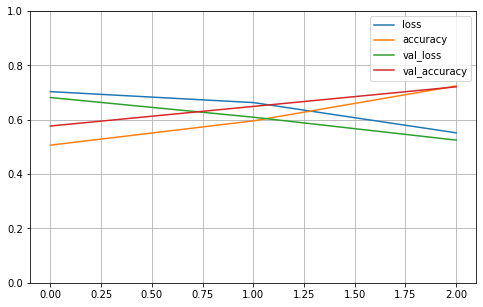

Train set ones/size 2224 / 4658
Compute valiation accuracy
Valid sizes (1165, 4997) (1165,)
Valid set ones/size 542 / 1165
Range of scores: 0.009869766 to 0.9802105
Score threshold 0.5
Prediction set ones/size 599 / 1165


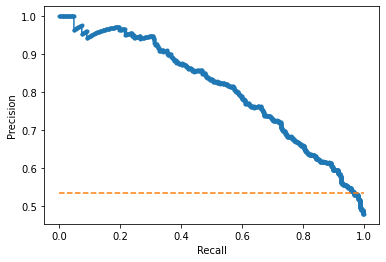

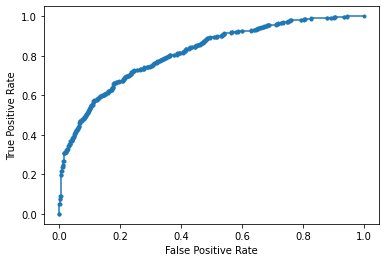

Accuracy: 72.10% Precision: 68.11% Recall: 75.28%
F1: 71.52% AUPRC: 80.91% AUROC: 81.63%
2023-02-06 14:14:02.739585
Fold 2
Model params (mean -2.20, wgt 0.62) (mean 0.25, wgt 0.38)
RCI threshold derived from training set: [-1.26490306]
FIT
2023-02-06 14:14:05.836152
Epoch 1/3
146/146 [==============================] - 3s 13ms/step - loss: 0.7002 - accuracy: 0.5112 - val_loss: 0.6703 - val_accuracy: 0.5940
Epoch 2/3
146/146 [==============================] - 2s 12ms/step - loss: 0.6422 - accuracy: 0.6222 - val_loss: 0.5850 - val_accuracy: 0.7039
Epoch 3/3
146/146 [==============================] - 2s 13ms/step - loss: 0.5453 - accuracy: 0.7211 - val_loss: 0.5254 - val_accuracy: 0.7382
PREDICT
2023-02-06 14:14:16.711893


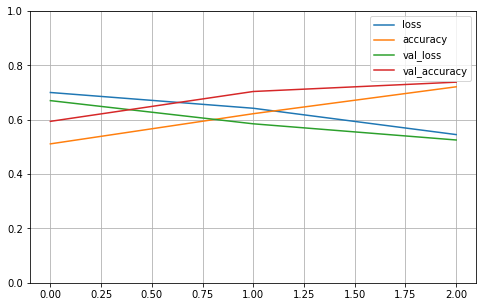

Train set ones/size 2243 / 4658
Compute valiation accuracy
Valid sizes (1165, 4997) (1165,)
Valid set ones/size 522 / 1165
Range of scores: 0.0066566267 to 0.9877038
Score threshold 0.5
Prediction set ones/size 585 / 1165


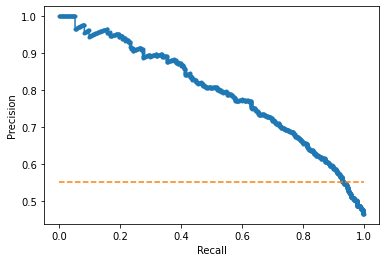

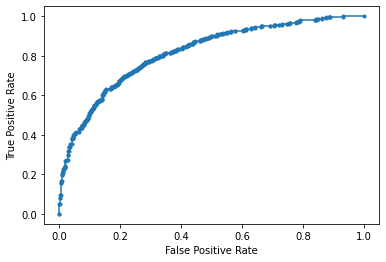

Accuracy: 73.82% Precision: 68.55% Recall: 76.82%
F1: 72.45% AUPRC: 79.50% AUROC: 81.77%
2023-02-06 14:14:17.500681
Fold 3
Model params (mean -2.21, wgt 0.62) (mean 0.23, wgt 0.38)
RCI threshold derived from training set: [-1.28839207]
FIT
2023-02-06 14:14:20.644998
Epoch 1/3
146/146 [==============================] - 3s 14ms/step - loss: 0.6959 - accuracy: 0.5367 - val_loss: 0.6536 - val_accuracy: 0.6489
Epoch 2/3
146/146 [==============================] - 2s 12ms/step - loss: 0.5857 - accuracy: 0.6844 - val_loss: 0.5471 - val_accuracy: 0.7150
Epoch 3/3
146/146 [==============================] - 2s 12ms/step - loss: 0.5215 - accuracy: 0.7398 - val_loss: 0.4974 - val_accuracy: 0.7588
PREDICT
2023-02-06 14:14:31.515973


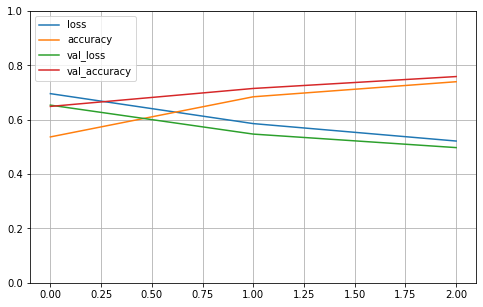

Train set ones/size 2240 / 4658
Compute valiation accuracy
Valid sizes (1165, 4997) (1165,)
Valid set ones/size 567 / 1165
Range of scores: 0.016261747 to 0.9800576
Score threshold 0.5
Prediction set ones/size 526 / 1165


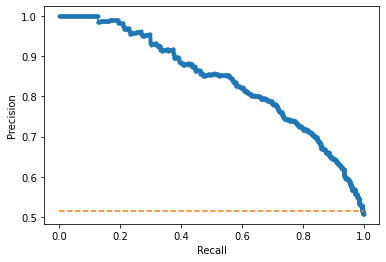

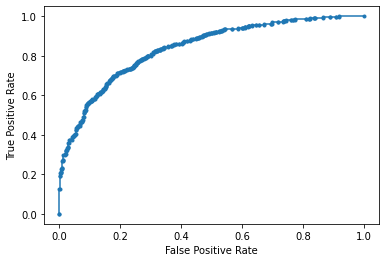

Accuracy: 75.88% Precision: 77.19% Recall: 71.60%
F1: 74.29% AUPRC: 84.03% AUROC: 83.86%
2023-02-06 14:14:32.303641
Fold 4
Model params (mean -2.23, wgt 0.62) (mean 0.23, wgt 0.38)
RCI threshold derived from training set: [-1.29473061]
FIT
2023-02-06 14:14:35.363349
Epoch 1/3
146/146 [==============================] - 3s 15ms/step - loss: 0.7006 - accuracy: 0.5246 - val_loss: 0.6814 - val_accuracy: 0.5172
Epoch 2/3
146/146 [==============================] - 2s 13ms/step - loss: 0.6148 - accuracy: 0.6553 - val_loss: 0.5944 - val_accuracy: 0.6813
Epoch 3/3
146/146 [==============================] - 2s 13ms/step - loss: 0.5238 - accuracy: 0.7416 - val_loss: 0.5928 - val_accuracy: 0.7010
PREDICT
2023-02-06 14:14:42.039249


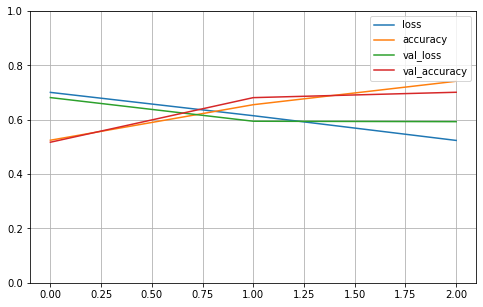

Train set ones/size 2229 / 4659
Compute valiation accuracy
Valid sizes (1164, 4997) (1164,)
Valid set ones/size 578 / 1164
Range of scores: 0.010661697 to 0.9946526
Score threshold 0.5
Prediction set ones/size 778 / 1164


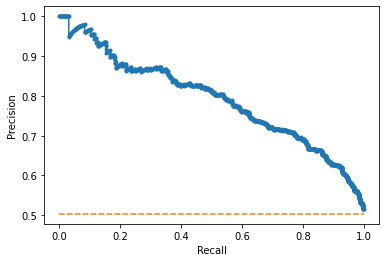

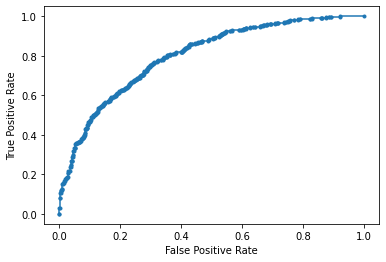

Accuracy: 70.10% Precision: 64.78% Recall: 87.20%
F1: 74.34% AUPRC: 79.25% AUROC: 80.09%
2023-02-06 14:14:42.670431
Fold 5
Model params (mean -2.21, wgt 0.62) (mean 0.21, wgt 0.38)
RCI threshold derived from training set: [-1.3037364]
FIT
2023-02-06 14:14:45.953529
Epoch 1/3
146/146 [==============================] - 3s 15ms/step - loss: 0.7027 - accuracy: 0.5203 - val_loss: 0.6901 - val_accuracy: 0.5352
Epoch 2/3
146/146 [==============================] - 2s 12ms/step - loss: 0.6539 - accuracy: 0.6141 - val_loss: 0.5980 - val_accuracy: 0.6847
Epoch 3/3
146/146 [==============================] - 2s 12ms/step - loss: 0.5346 - accuracy: 0.7356 - val_loss: 0.5584 - val_accuracy: 0.7182
PREDICT
2023-02-06 14:14:56.840238


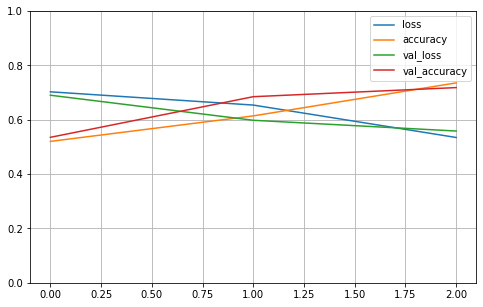

Train set ones/size 2238 / 4659
Compute valiation accuracy
Valid sizes (1164, 4997) (1164,)
Valid set ones/size 585 / 1164
Range of scores: 0.0027166267 to 0.9961591
Score threshold 0.5
Prediction set ones/size 789 / 1164


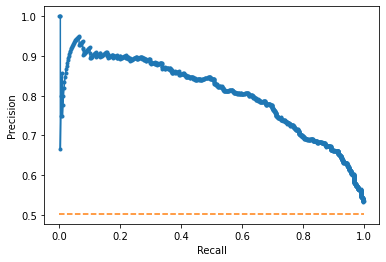

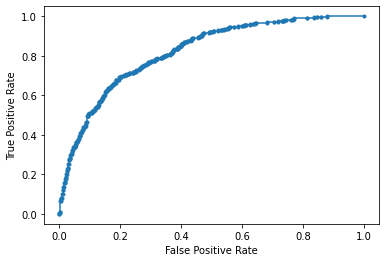

Accuracy: 71.82% Precision: 66.29% Recall: 89.40%
F1: 76.13% AUPRC: 80.47% AUROC: 82.15%
2023-02-06 14:14:57.498045

Completed cross validation 5 folds 3 epochs
 accuracy mean 72.75% +/- 1.96
 precision mean 68.98% +/- 4.32
 recall mean 80.06% +/- 6.97
 F1 mean 73.74% +/- 1.61
 AUPRC mean 80.83% +/- 1.71
 AUROC mean 81.90% +/- 1.21
Finished cell Line 2 HeLa.S3

2023-02-06 14:14:58.796070
Start cell Line 3 HepG2
Number of RCI values loaded 1362
Num RCI: 1362
Load sequence...
Cross validation...
2023-02-06 14:15:10.194319
splitting
Fold 1
Model params (mean -1.90, wgt 0.61) (mean 0.21, wgt 0.39)
RCI threshold derived from training set: [-1.08233554]
FIT
2023-02-06 14:15:13.273137
Epoch 1/3
211/211 [==============================] - 3s 13ms/step - loss: 0.7006 - accuracy: 0.5149 - val_loss: 0.6783 - val_accuracy: 0.5729
Epoch 2/3
211/211 [==============================] - 3s 12ms/step - loss: 0.6435 - accuracy: 0.6229 - val_loss: 0.5825 - val_accuracy: 0.6949
Epoch 3/3
211/211 [==========

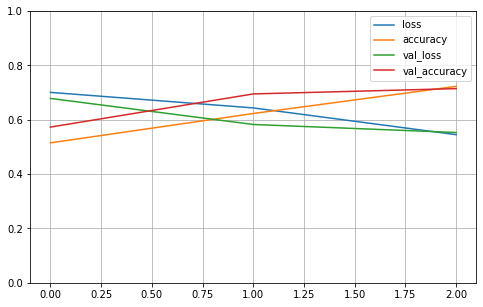

Train set ones/size 3234 / 6751
Compute valiation accuracy
Valid sizes (1688, 4997) (1688,)
Valid set ones/size 815 / 1688
Range of scores: 0.0050411406 to 0.9562515
Score threshold 0.5
Prediction set ones/size 545 / 1688


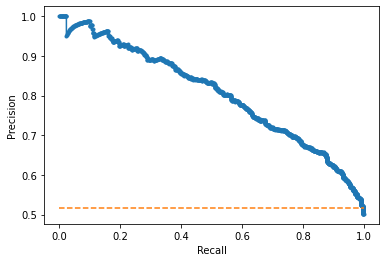

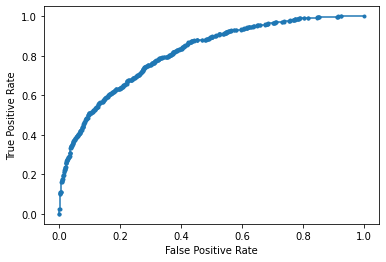

Accuracy: 71.45% Precision: 80.55% Recall: 53.87%
F1: 64.56% AUPRC: 80.54% AUROC: 81.35%
2023-02-06 14:15:22.563252
Fold 2
Model params (mean -1.89, wgt 0.61) (mean 0.19, wgt 0.39)
RCI threshold derived from training set: [-1.07251161]
FIT
2023-02-06 14:15:26.354835
Epoch 1/3
211/211 [==============================] - 3s 13ms/step - loss: 0.6978 - accuracy: 0.5232 - val_loss: 0.6761 - val_accuracy: 0.5764
Epoch 2/3
211/211 [==============================] - 2s 12ms/step - loss: 0.6241 - accuracy: 0.6460 - val_loss: 0.5900 - val_accuracy: 0.6866
Epoch 3/3
211/211 [==============================] - 3s 12ms/step - loss: 0.5414 - accuracy: 0.7328 - val_loss: 0.5557 - val_accuracy: 0.7162
PREDICT
2023-02-06 14:15:37.256439


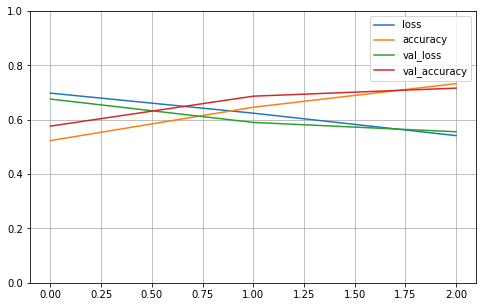

Train set ones/size 3260 / 6751
Compute valiation accuracy
Valid sizes (1688, 4997) (1688,)
Valid set ones/size 782 / 1688
Range of scores: 0.0039928546 to 0.9637224
Score threshold 0.5
Prediction set ones/size 479 / 1688


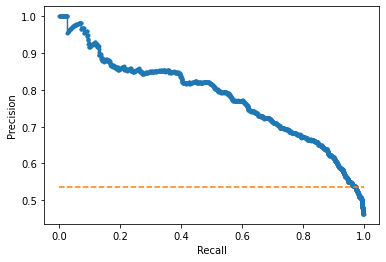

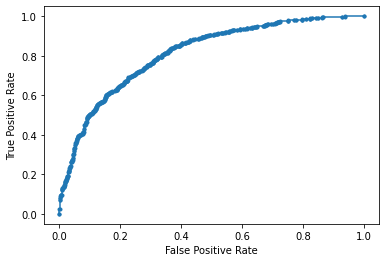

Accuracy: 71.62% Precision: 81.63% Recall: 50.00%
F1: 62.01% AUPRC: 78.06% AUROC: 81.23%
2023-02-06 14:15:38.066653
Fold 3
Model params (mean -1.92, wgt 0.61) (mean 0.26, wgt 0.39)
RCI threshold derived from training set: [-1.08081677]
FIT
2023-02-06 14:15:42.085733
Epoch 1/3
211/211 [==============================] - 3s 14ms/step - loss: 0.6902 - accuracy: 0.5387 - val_loss: 0.6459 - val_accuracy: 0.6297
Epoch 2/3
211/211 [==============================] - 3s 12ms/step - loss: 0.6115 - accuracy: 0.6638 - val_loss: 0.5897 - val_accuracy: 0.6878
Epoch 3/3
211/211 [==============================] - 3s 12ms/step - loss: 0.5297 - accuracy: 0.7383 - val_loss: 0.5214 - val_accuracy: 0.7399
PREDICT
2023-02-06 14:15:52.984560


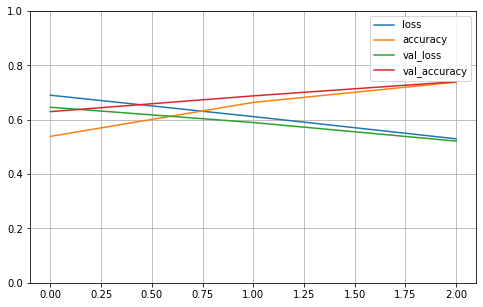

Train set ones/size 3204 / 6751
Compute valiation accuracy
Valid sizes (1688, 4997) (1688,)
Valid set ones/size 838 / 1688
Range of scores: 0.00341001 to 0.99619734
Score threshold 0.5
Prediction set ones/size 835 / 1688


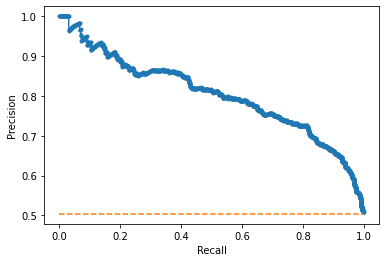

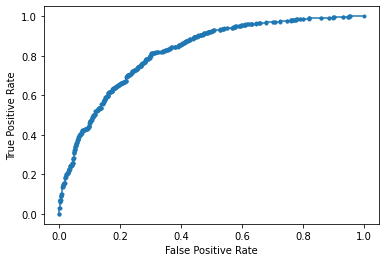

Accuracy: 73.99% Precision: 73.89% Recall: 73.63%
F1: 73.76% AUPRC: 80.37% AUROC: 81.96%
2023-02-06 14:15:53.776102
Fold 4
Model params (mean 0.12, wgt 0.40) (mean -1.91, wgt 0.60)
RCI threshold derived from training set: [-1.09004343]
FIT
2023-02-06 14:15:57.684883
Epoch 1/3
211/211 [==============================] - 3s 14ms/step - loss: 0.6964 - accuracy: 0.5273 - val_loss: 0.6766 - val_accuracy: 0.5746
Epoch 2/3
211/211 [==============================] - 3s 12ms/step - loss: 0.6129 - accuracy: 0.6578 - val_loss: 0.6077 - val_accuracy: 0.6765
Epoch 3/3
211/211 [==============================] - 3s 13ms/step - loss: 0.5410 - accuracy: 0.7236 - val_loss: 0.5546 - val_accuracy: 0.6991
PREDICT
2023-02-06 14:16:06.564525


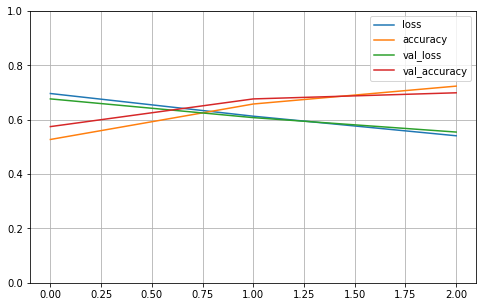

Train set ones/size 3258 / 6751
Compute valiation accuracy
Valid sizes (1688, 4997) (1688,)
Valid set ones/size 803 / 1688
Range of scores: 0.005643024 to 0.9856208
Score threshold 0.5
Prediction set ones/size 611 / 1688


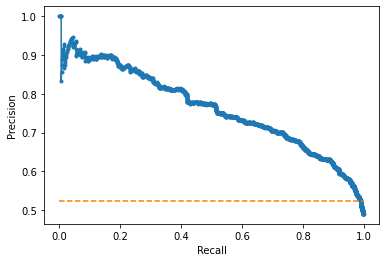

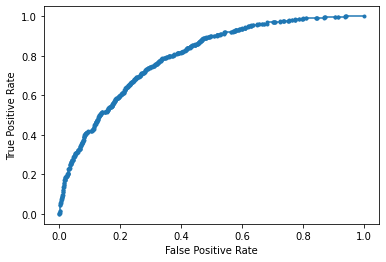

Accuracy: 69.91% Precision: 74.14% Recall: 56.41%
F1: 64.07% AUPRC: 76.30% AUROC: 79.55%
2023-02-06 14:16:07.271866
Fold 5
Model params (mean 0.18, wgt 0.39) (mean -1.89, wgt 0.61)
RCI threshold derived from training set: [-1.08347741]
FIT
2023-02-06 14:16:11.207912
Epoch 1/3
211/211 [==============================] - 3s 13ms/step - loss: 0.6938 - accuracy: 0.5404 - val_loss: 0.6318 - val_accuracy: 0.6663
Epoch 2/3
211/211 [==============================] - 2s 12ms/step - loss: 0.6169 - accuracy: 0.6565 - val_loss: 0.6261 - val_accuracy: 0.6396
Epoch 3/3
211/211 [==============================] - 2s 12ms/step - loss: 0.5350 - accuracy: 0.7328 - val_loss: 0.5533 - val_accuracy: 0.7208
PREDICT
2023-02-06 14:16:22.068440


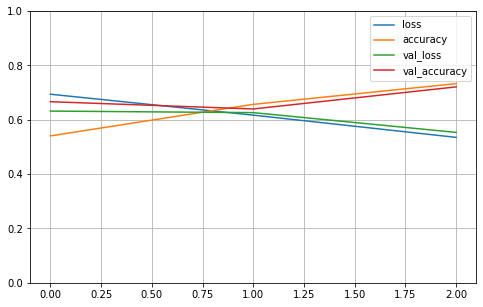

Train set ones/size 3242 / 6752
Compute valiation accuracy
Valid sizes (1687, 4997) (1687,)
Valid set ones/size 816 / 1687
Range of scores: 0.0014774384 to 0.96313995
Score threshold 0.5
Prediction set ones/size 649 / 1687


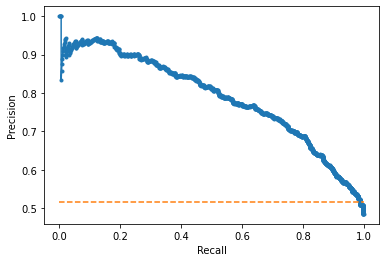

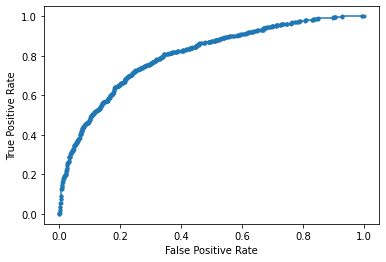

Accuracy: 72.08% Precision: 76.58% Recall: 60.91%
F1: 67.85% AUPRC: 78.98% AUROC: 80.25%
2023-02-06 14:16:22.850864

Completed cross validation 5 folds 3 epochs
 accuracy mean 71.81% +/- 1.31
 precision mean 77.36% +/- 3.21
 recall mean 58.96% +/- 8.14
 F1 mean 66.45% +/- 4.11
 AUPRC mean 78.85% +/- 1.57
 AUROC mean 80.87% +/- 0.86
Finished cell Line 3 HepG2

2023-02-06 14:16:24.205900
Start cell Line 4 HT1080
Number of RCI values loaded 936
Num RCI: 936
Load sequence...
Cross validation...
2023-02-06 14:16:33.667510
splitting
Fold 1
Model params (mean -0.99, wgt 0.62) (mean 0.90, wgt 0.38)
RCI threshold derived from training set: [-0.27477172]
FIT
2023-02-06 14:16:35.917727
Epoch 1/3
177/177 [==============================] - 3s 14ms/step - loss: 0.6984 - accuracy: 0.5288 - val_loss: 0.6617 - val_accuracy: 0.6192
Epoch 2/3
177/177 [==============================] - 2s 13ms/step - loss: 0.6133 - accuracy: 0.6620 - val_loss: 0.5833 - val_accuracy: 0.6851
Epoch 3/3
177/177 [=============

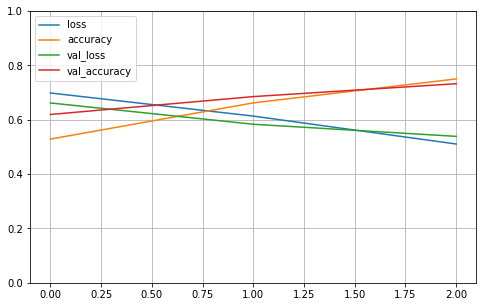

Train set ones/size 2724 / 5651
Compute valiation accuracy
Valid sizes (1413, 4997) (1413,)
Valid set ones/size 666 / 1413
Range of scores: 0.0033063702 to 0.9944382
Score threshold 0.5
Prediction set ones/size 698 / 1413


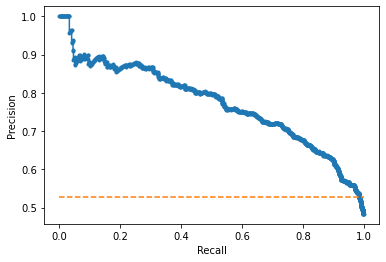

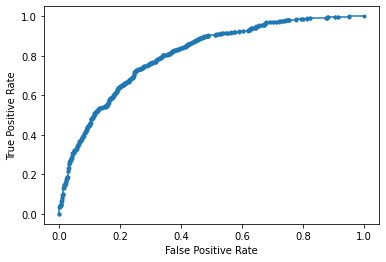

Accuracy: 73.25% Precision: 70.63% Recall: 74.02%
F1: 72.29% AUPRC: 77.39% AUROC: 80.60%
2023-02-06 14:16:44.414806
Fold 2
Model params (mean 0.99, wgt 0.38) (mean -1.07, wgt 0.62)
RCI threshold derived from training set: [-0.28422935]
FIT
2023-02-06 14:16:47.974354
Epoch 1/3
177/177 [==============================] - 3s 14ms/step - loss: 0.7008 - accuracy: 0.5155 - val_loss: 0.6740 - val_accuracy: 0.5704
Epoch 2/3
177/177 [==============================] - 2s 12ms/step - loss: 0.6385 - accuracy: 0.6379 - val_loss: 0.5791 - val_accuracy: 0.6695
Epoch 3/3
177/177 [==============================] - 2s 12ms/step - loss: 0.5239 - accuracy: 0.7395 - val_loss: 0.6117 - val_accuracy: 0.6837
PREDICT
2023-02-06 14:16:55.395072


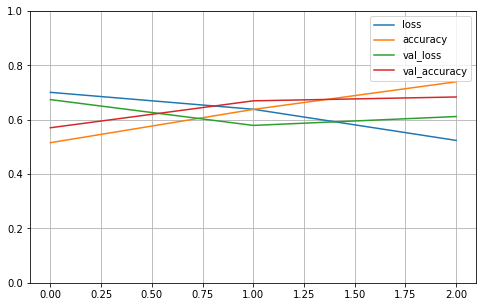

Train set ones/size 2700 / 5651
Compute valiation accuracy
Valid sizes (1413, 4997) (1413,)
Valid set ones/size 697 / 1413
Range of scores: 0.016147653 to 0.994491
Score threshold 0.5
Prediction set ones/size 1022 / 1413


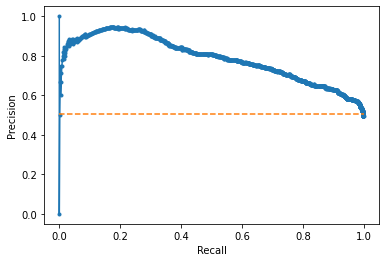

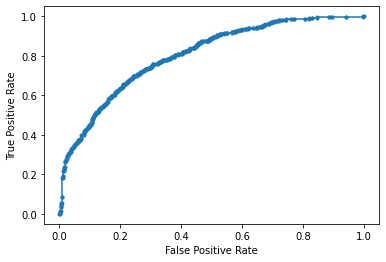

Accuracy: 68.37% Precision: 62.23% Recall: 91.25%
F1: 74.00% AUPRC: 78.70% AUROC: 80.33%
2023-02-06 14:16:56.198322
Fold 3
Model params (mean 0.97, wgt 0.37) (mean -1.02, wgt 0.63)
RCI threshold derived from training set: [-0.2817297]
FIT
2023-02-06 14:16:59.728073
Epoch 1/3
177/177 [==============================] - 3s 14ms/step - loss: 0.6964 - accuracy: 0.5224 - val_loss: 0.6805 - val_accuracy: 0.5513
Epoch 2/3
177/177 [==============================] - 2s 13ms/step - loss: 0.6293 - accuracy: 0.6424 - val_loss: 0.5587 - val_accuracy: 0.7006
Epoch 3/3
177/177 [==============================] - 2s 12ms/step - loss: 0.5063 - accuracy: 0.7551 - val_loss: 0.5732 - val_accuracy: 0.6999
PREDICT
2023-02-06 14:17:10.631969


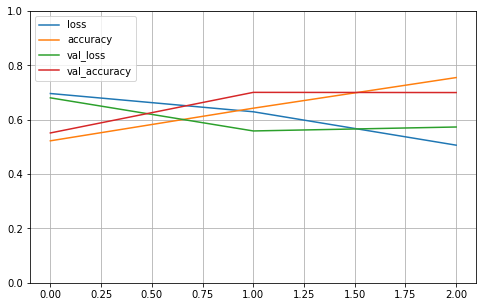

Train set ones/size 2717 / 5651
Compute valiation accuracy
Valid sizes (1413, 4997) (1413,)
Valid set ones/size 680 / 1413
Range of scores: 0.015492727 to 0.99433917
Score threshold 0.5
Prediction set ones/size 950 / 1413


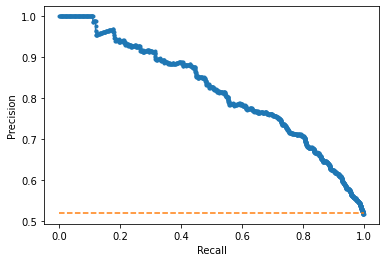

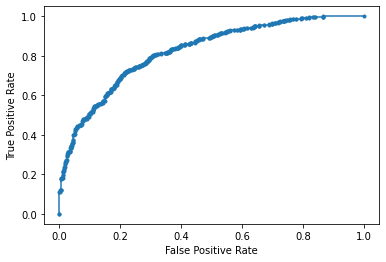

Accuracy: 69.99% Precision: 63.47% Recall: 88.68%
F1: 73.99% AUPRC: 81.79% AUROC: 82.37%
2023-02-06 14:17:11.443555
Fold 4
Model params (mean 0.96, wgt 0.37) (mean -1.03, wgt 0.63)
RCI threshold derived from training set: [-0.28577885]
FIT
2023-02-06 14:17:15.210081
Epoch 1/3
177/177 [==============================] - 3s 14ms/step - loss: 0.7010 - accuracy: 0.5293 - val_loss: 0.6644 - val_accuracy: 0.6192
Epoch 2/3
177/177 [==============================] - 2s 13ms/step - loss: 0.6210 - accuracy: 0.6544 - val_loss: 0.5610 - val_accuracy: 0.7155
Epoch 3/3
177/177 [==============================] - 2s 13ms/step - loss: 0.5189 - accuracy: 0.7478 - val_loss: 0.4887 - val_accuracy: 0.7714
PREDICT
2023-02-06 14:17:22.876322


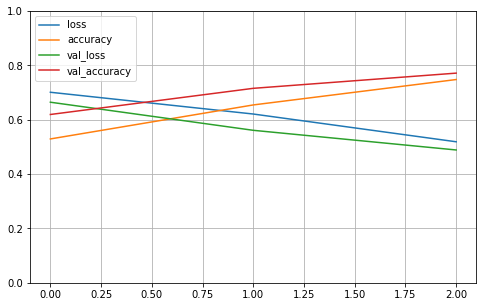

Train set ones/size 2722 / 5651
Compute valiation accuracy
Valid sizes (1413, 4997) (1413,)
Valid set ones/size 675 / 1413
Range of scores: 0.009734389 to 0.9744364
Score threshold 0.5
Prediction set ones/size 728 / 1413


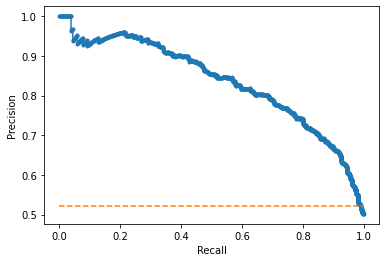

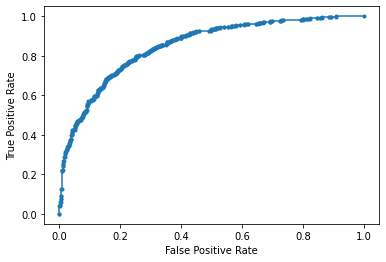

Accuracy: 77.14% Precision: 74.18% Recall: 80.00%
F1: 76.98% AUPRC: 83.57% AUROC: 85.00%
2023-02-06 14:17:23.526147
Fold 5
Model params (mean -1.04, wgt 0.62) (mean 0.95, wgt 0.38)
RCI threshold derived from training set: [-0.29001993]
FIT
2023-02-06 14:17:27.060671
Epoch 1/3
177/177 [==============================] - 3s 14ms/step - loss: 0.6940 - accuracy: 0.5412 - val_loss: 0.6462 - val_accuracy: 0.6310
Epoch 2/3
177/177 [==============================] - 2s 12ms/step - loss: 0.6283 - accuracy: 0.6430 - val_loss: 0.5792 - val_accuracy: 0.6933
Epoch 3/3
177/177 [==============================] - 2s 13ms/step - loss: 0.5491 - accuracy: 0.7143 - val_loss: 0.5484 - val_accuracy: 0.7167
PREDICT
2023-02-06 14:17:37.949781


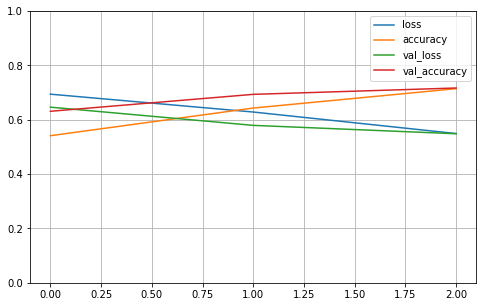

Train set ones/size 2724 / 5652
Compute valiation accuracy
Valid sizes (1412, 4997) (1412,)
Valid set ones/size 678 / 1412
Range of scores: 0.002451998 to 0.9772174
Score threshold 0.5
Prediction set ones/size 564 / 1412


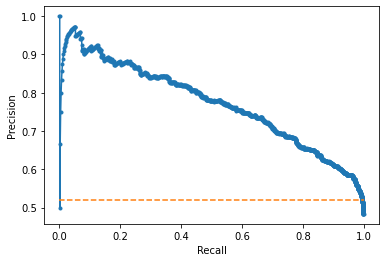

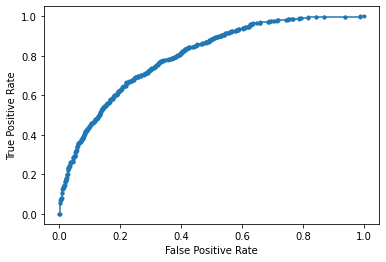

Accuracy: 71.67% Precision: 74.65% Recall: 62.09%
F1: 67.79% AUPRC: 77.21% AUROC: 79.86%
2023-02-06 14:17:38.747910

Completed cross validation 5 folds 3 epochs
 accuracy mean 72.08% +/- 3.01
 precision mean 69.03% +/- 5.25
 recall mean 79.21% +/- 10.54
 F1 mean 73.01% +/- 3.01
 AUPRC mean 79.73% +/- 2.53
 AUROC mean 81.63% +/- 1.89
Finished cell Line 4 HT1080

2023-02-06 14:17:40.097856
Start cell Line 5 HUVEC
Number of RCI values loaded 1488
Num RCI: 1488
Load sequence...
Cross validation...
2023-02-06 14:17:52.927542
splitting
Fold 1
Model params (mean -2.02, wgt 0.48) (mean -0.00, wgt 0.52)
RCI threshold derived from training set: [-0.96692993]
FIT
2023-02-06 14:17:55.980844
Epoch 1/3
240/240 [==============================] - 4s 14ms/step - loss: 0.6957 - accuracy: 0.5274 - val_loss: 0.6476 - val_accuracy: 0.6277
Epoch 2/3
240/240 [==============================] - 3s 12ms/step - loss: 0.6149 - accuracy: 0.6624 - val_loss: 0.5708 - val_accuracy: 0.6960
Epoch 3/3
240/240 [=========

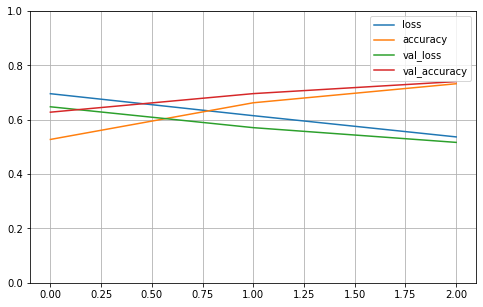

Train set ones/size 3932 / 7671
Compute valiation accuracy
Valid sizes (1918, 4997) (1918,)
Valid set ones/size 1019 / 1918
Range of scores: 0.0067578186 to 0.9936272
Score threshold 0.5
Prediction set ones/size 1141 / 1918


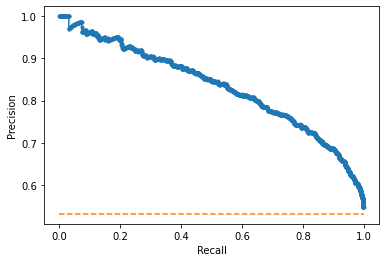

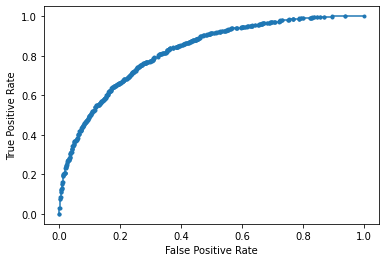

Accuracy: 74.04% Precision: 72.83% Recall: 81.55%
F1: 76.94% AUPRC: 83.36% AUROC: 82.17%
2023-02-06 14:18:07.732553
Fold 2
Model params (mean -0.03, wgt 0.53) (mean -2.00, wgt 0.47)
RCI threshold derived from training set: [-0.95009136]
FIT
2023-02-06 14:18:12.248707
Epoch 1/3
240/240 [==============================] - 4s 14ms/step - loss: 0.6920 - accuracy: 0.5413 - val_loss: 0.6604 - val_accuracy: 0.5892
Epoch 2/3
240/240 [==============================] - 3s 12ms/step - loss: 0.6084 - accuracy: 0.6665 - val_loss: 0.6219 - val_accuracy: 0.6548
Epoch 3/3
240/240 [==============================] - 3s 13ms/step - loss: 0.5062 - accuracy: 0.7527 - val_loss: 0.5543 - val_accuracy: 0.7122
PREDICT
2023-02-06 14:18:22.296542


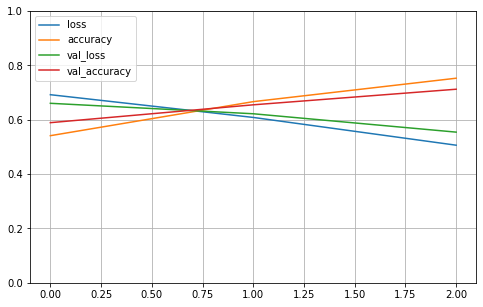

Train set ones/size 3928 / 7671
Compute valiation accuracy
Valid sizes (1918, 4997) (1918,)
Valid set ones/size 948 / 1918
Range of scores: 0.00071296113 to 0.99456704
Score threshold 0.5
Prediction set ones/size 1210 / 1918


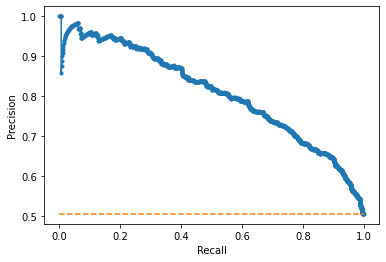

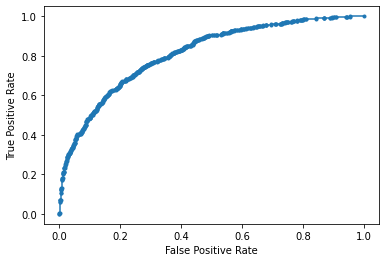

Accuracy: 71.22% Precision: 66.36% Recall: 84.70%
F1: 74.42% AUPRC: 80.82% AUROC: 81.16%
2023-02-06 14:18:23.361785
Fold 3
Model params (mean -0.02, wgt 0.53) (mean -2.03, wgt 0.47)
RCI threshold derived from training set: [-0.97561892]
FIT
2023-02-06 14:18:27.623871
Epoch 1/3
240/240 [==============================] - 4s 13ms/step - loss: 0.6926 - accuracy: 0.5380 - val_loss: 0.6907 - val_accuracy: 0.5339
Epoch 2/3
240/240 [==============================] - 3s 12ms/step - loss: 0.6099 - accuracy: 0.6646 - val_loss: 0.5894 - val_accuracy: 0.6788
Epoch 3/3
240/240 [==============================] - 3s 12ms/step - loss: 0.5249 - accuracy: 0.7436 - val_loss: 0.5368 - val_accuracy: 0.7372
PREDICT
2023-02-06 14:18:37.475558


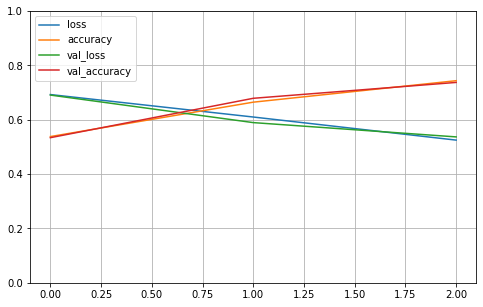

Train set ones/size 3948 / 7671
Compute valiation accuracy
Valid sizes (1918, 4997) (1918,)
Valid set ones/size 1019 / 1918
Range of scores: 0.00040714076 to 0.9916338
Score threshold 0.5
Prediction set ones/size 1183 / 1918


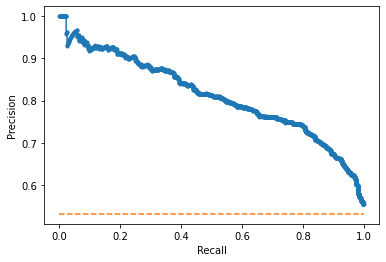

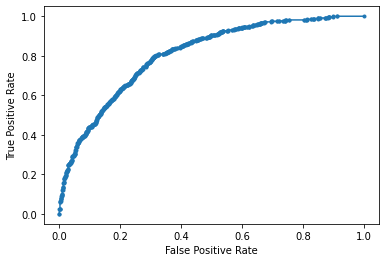

Accuracy: 73.72% Precision: 71.77% Recall: 83.32%
F1: 77.11% AUPRC: 81.23% AUROC: 80.67%
2023-02-06 14:18:38.284023
Fold 4
Model params (mean 0.02, wgt 0.52) (mean -1.99, wgt 0.48)
RCI threshold derived from training set: [-0.93469946]
FIT
2023-02-06 14:18:42.567772
Epoch 1/3
240/240 [==============================] - 4s 13ms/step - loss: 0.6946 - accuracy: 0.5310 - val_loss: 0.6625 - val_accuracy: 0.6204
Epoch 2/3
240/240 [==============================] - 3s 12ms/step - loss: 0.6320 - accuracy: 0.6483 - val_loss: 0.5960 - val_accuracy: 0.6700
Epoch 3/3
240/240 [==============================] - 3s 13ms/step - loss: 0.5548 - accuracy: 0.7243 - val_loss: 0.5652 - val_accuracy: 0.7106
PREDICT
2023-02-06 14:18:53.487048


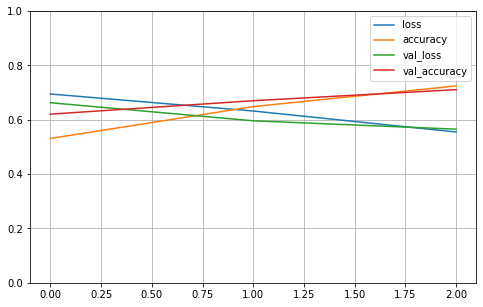

Train set ones/size 3893 / 7671
Compute valiation accuracy
Valid sizes (1918, 4997) (1918,)
Valid set ones/size 943 / 1918
Range of scores: 0.0006310513 to 0.9877801
Score threshold 0.5
Prediction set ones/size 722 / 1918


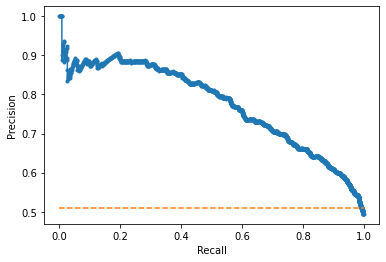

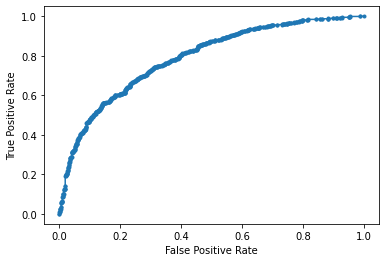

Accuracy: 71.06% Precision: 76.87% Recall: 58.85%
F1: 66.67% AUPRC: 77.54% AUROC: 79.02%
2023-02-06 14:18:54.224997
Fold 5
Model params (mean 0.01, wgt 0.53) (mean -2.04, wgt 0.47)
RCI threshold derived from training set: [-0.96065792]
FIT
2023-02-06 14:18:58.364530
Epoch 1/3
240/240 [==============================] - 4s 13ms/step - loss: 0.6978 - accuracy: 0.5182 - val_loss: 0.6840 - val_accuracy: 0.5587
Epoch 2/3
240/240 [==============================] - 3s 13ms/step - loss: 0.6467 - accuracy: 0.6216 - val_loss: 0.6013 - val_accuracy: 0.6750
Epoch 3/3
240/240 [==============================] - 3s 12ms/step - loss: 0.5591 - accuracy: 0.7136 - val_loss: 0.5320 - val_accuracy: 0.7256
PREDICT
2023-02-06 14:19:09.292593


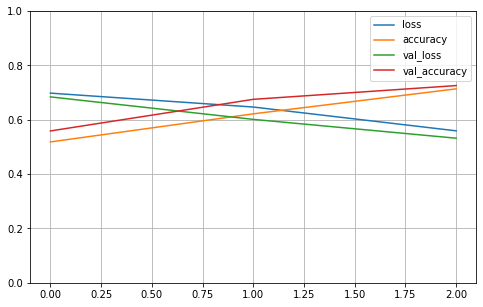

Train set ones/size 3956 / 7672
Compute valiation accuracy
Valid sizes (1917, 4997) (1917,)
Valid set ones/size 980 / 1917
Range of scores: 0.003248825 to 0.9819723
Score threshold 0.5
Prediction set ones/size 970 / 1917


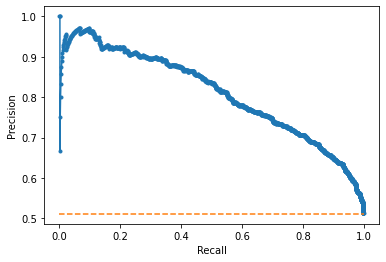

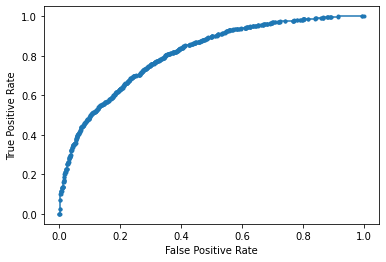

Accuracy: 72.56% Precision: 73.40% Recall: 72.65%
F1: 73.03% AUPRC: 81.00% AUROC: 80.94%
2023-02-06 14:19:10.022077

Completed cross validation 5 folds 3 epochs
 accuracy mean 72.52% +/- 1.23
 precision mean 72.25% +/- 3.40
 recall mean 76.22% +/- 9.64
 F1 mean 73.63% +/- 3.81
 AUPRC mean 80.79% +/- 1.87
 AUROC mean 80.79% +/- 1.02
Finished cell Line 5 HUVEC

2023-02-06 14:19:11.396360
Start cell Line 6 MCF.7
Number of RCI values loaded 2156
Num RCI: 2156
Load sequence...
Cross validation...
2023-02-06 14:19:26.620498
splitting
Fold 1
Model params (mean -0.10, wgt 0.48) (mean -2.13, wgt 0.52)
RCI threshold derived from training set: [-1.14340922]
FIT
2023-02-06 14:19:30.187070
Epoch 1/3
289/289 [==============================] - 4s 13ms/step - loss: 0.6985 - accuracy: 0.5190 - val_loss: 0.6685 - val_accuracy: 0.6155
Epoch 2/3
289/289 [==============================] - 3s 12ms/step - loss: 0.6392 - accuracy: 0.6261 - val_loss: 0.5984 - val_accuracy: 0.6706
Epoch 3/3
289/289 [===========

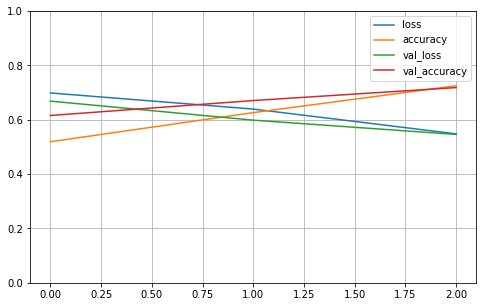

Train set ones/size 4691 / 9228
Compute valiation accuracy
Valid sizes (2307, 4997) (2307,)
Valid set ones/size 1228 / 2307
Range of scores: 0.010949414 to 0.991439
Score threshold 0.5
Prediction set ones/size 1220 / 2307


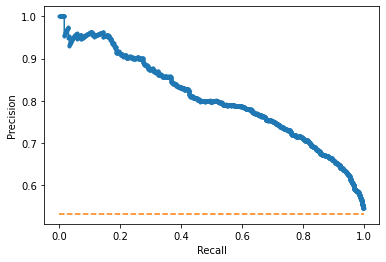

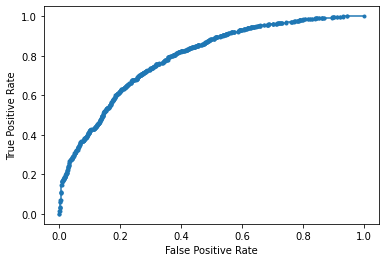

Accuracy: 71.82% Precision: 73.69% Recall: 73.21%
F1: 73.45% AUPRC: 80.60% AUROC: 79.29%
2023-02-06 14:19:42.607271
Fold 2
Model params (mean -2.17, wgt 0.51) (mean -0.02, wgt 0.49)
RCI threshold derived from training set: [-1.11719313]
FIT
2023-02-06 14:19:47.454776
Epoch 1/3
289/289 [==============================] - 4s 13ms/step - loss: 0.6956 - accuracy: 0.5294 - val_loss: 0.6774 - val_accuracy: 0.5761
Epoch 2/3
289/289 [==============================] - 4s 12ms/step - loss: 0.6464 - accuracy: 0.6230 - val_loss: 0.6272 - val_accuracy: 0.6290
Epoch 3/3
289/289 [==============================] - 4s 13ms/step - loss: 0.5815 - accuracy: 0.6901 - val_loss: 0.6176 - val_accuracy: 0.6389
PREDICT
2023-02-06 14:20:08.656173


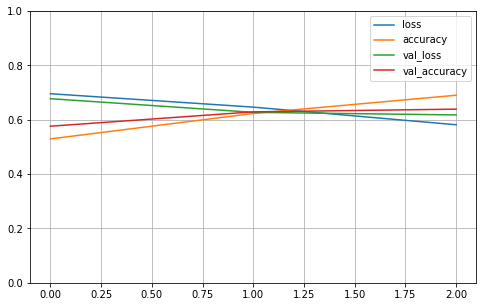

Train set ones/size 4723 / 9228
Compute valiation accuracy
Valid sizes (2307, 4997) (2307,)
Valid set ones/size 1171 / 2307
Range of scores: 0.02720522 to 0.98210514
Score threshold 0.5
Prediction set ones/size 1770 / 2307


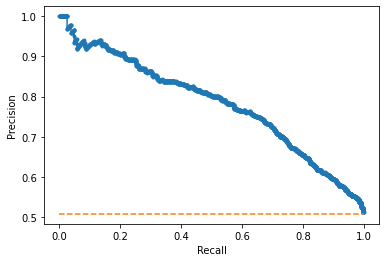

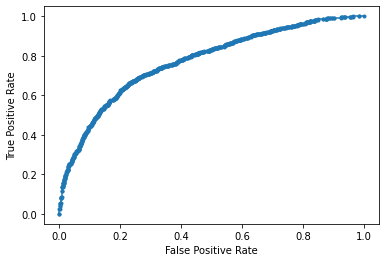

Accuracy: 63.89% Precision: 59.55% Recall: 90.01%
F1: 71.68% AUPRC: 78.24% AUROC: 77.33%
2023-02-06 14:20:09.792261
Fold 3
Model params (mean -0.09, wgt 0.50) (mean -2.13, wgt 0.50)
RCI threshold derived from training set: [-1.10959769]
FIT
2023-02-06 14:20:14.641873
Epoch 1/3
289/289 [==============================] - 4s 13ms/step - loss: 0.6919 - accuracy: 0.5472 - val_loss: 0.6513 - val_accuracy: 0.6229
Epoch 2/3
289/289 [==============================] - 4s 12ms/step - loss: 0.6346 - accuracy: 0.6382 - val_loss: 0.5967 - val_accuracy: 0.6736
Epoch 3/3
289/289 [==============================] - 4s 13ms/step - loss: 0.5700 - accuracy: 0.7034 - val_loss: 0.5707 - val_accuracy: 0.7035
PREDICT
2023-02-06 14:20:26.605842


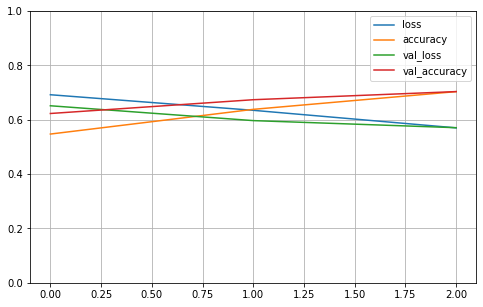

Train set ones/size 4754 / 9228
Compute valiation accuracy
Valid sizes (2307, 4997) (2307,)
Valid set ones/size 1133 / 2307
Range of scores: 0.010436874 to 0.9803505
Score threshold 0.5
Prediction set ones/size 799 / 2307


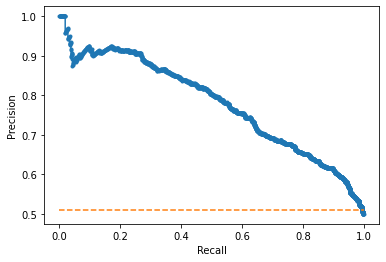

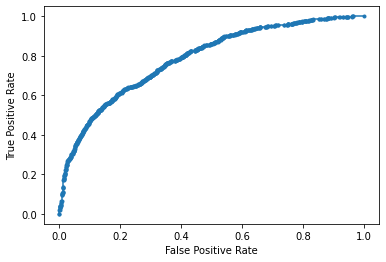

Accuracy: 70.35% Precision: 78.10% Recall: 55.08%
F1: 64.60% AUPRC: 77.99% AUROC: 78.63%
2023-02-06 14:20:27.435620
Fold 4
Model params (mean -0.07, wgt 0.49) (mean -2.13, wgt 0.51)
RCI threshold derived from training set: [-1.12810821]
FIT
2023-02-06 14:20:32.188971
Epoch 1/3
289/289 [==============================] - 5s 14ms/step - loss: 0.6938 - accuracy: 0.5271 - val_loss: 0.6700 - val_accuracy: 0.5882
Epoch 2/3
289/289 [==============================] - 4s 12ms/step - loss: 0.6372 - accuracy: 0.6360 - val_loss: 0.6120 - val_accuracy: 0.6693
Epoch 3/3
289/289 [==============================] - 4s 12ms/step - loss: 0.5628 - accuracy: 0.7160 - val_loss: 0.5766 - val_accuracy: 0.6944
PREDICT
2023-02-06 14:20:44.144330


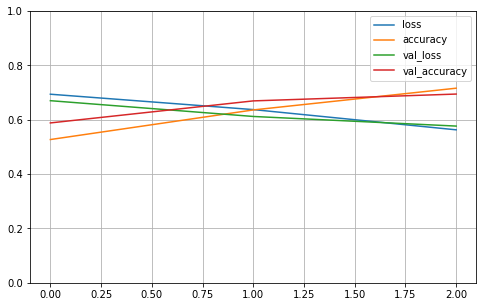

Train set ones/size 4725 / 9228
Compute valiation accuracy
Valid sizes (2307, 4997) (2307,)
Valid set ones/size 1191 / 2307
Range of scores: 0.011787415 to 0.99570197
Score threshold 0.5
Prediction set ones/size 1484 / 2307


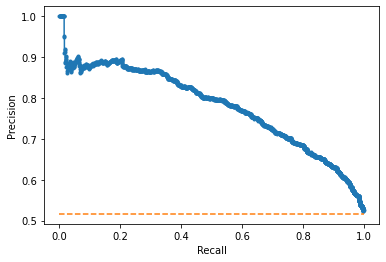

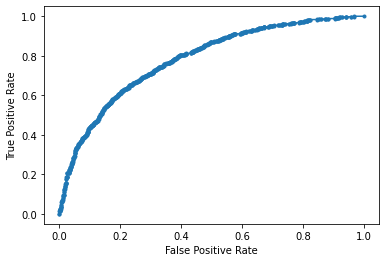

Accuracy: 69.44% Precision: 66.37% Recall: 82.70%
F1: 73.64% AUPRC: 78.04% AUROC: 78.22%
2023-02-06 14:20:44.923555
Fold 5
Model params (mean -0.05, wgt 0.48) (mean -2.12, wgt 0.52)
RCI threshold derived from training set: [-1.12050944]
FIT
2023-02-06 14:20:49.598738
Epoch 1/3
289/289 [==============================] - 4s 13ms/step - loss: 0.6970 - accuracy: 0.5186 - val_loss: 0.6742 - val_accuracy: 0.5912
Epoch 2/3
289/289 [==============================] - 4s 12ms/step - loss: 0.6422 - accuracy: 0.6344 - val_loss: 0.6194 - val_accuracy: 0.6524
Epoch 3/3
289/289 [==============================] - 4s 12ms/step - loss: 0.5639 - accuracy: 0.7037 - val_loss: 0.6049 - val_accuracy: 0.6697
PREDICT
2023-02-06 14:21:10.798919


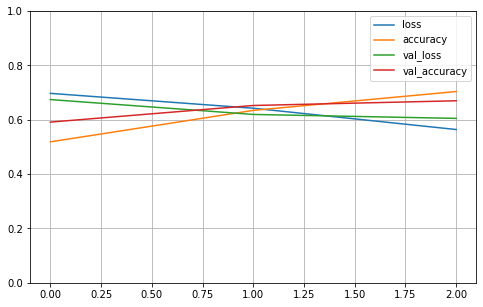

Train set ones/size 4716 / 9228
Compute valiation accuracy
Valid sizes (2307, 4997) (2307,)
Valid set ones/size 1179 / 2307
Range of scores: 0.0020962518 to 0.97092396
Score threshold 0.5
Prediction set ones/size 935 / 2307


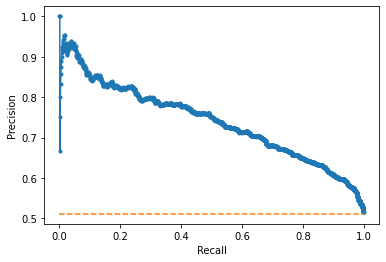

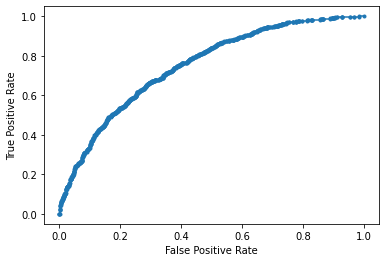

Accuracy: 66.97% Precision: 72.30% Recall: 57.34%
F1: 63.95% AUPRC: 74.02% AUROC: 75.03%
2023-02-06 14:21:11.936985

Completed cross validation 5 folds 3 epochs
 accuracy mean 68.50% +/- 2.79
 precision mean 70.00% +/- 6.43
 recall mean 71.67% +/- 13.72
 F1 mean 69.46% +/- 4.30
 AUPRC mean 77.78% +/- 2.12
 AUROC mean 77.70% +/- 1.48
Finished cell Line 6 MCF.7

2023-02-06 14:21:13.365286
Start cell Line 7 NCI.H460
Number of RCI values loaded 610
Num RCI: 610
Load sequence...
Cross validation...
2023-02-06 14:21:20.225860
splitting
Fold 1
Model params (mean -1.82, wgt 0.51) (mean -0.75, wgt 0.49)
RCI threshold derived from training set: [-1.30030198]
FIT
2023-02-06 14:21:21.868027
Epoch 1/3
131/131 [==============================] - 2s 14ms/step - loss: 0.7040 - accuracy: 0.5145 - val_loss: 0.6804 - val_accuracy: 0.5843
Epoch 2/3
131/131 [==============================] - 2s 12ms/step - loss: 0.6508 - accuracy: 0.6129 - val_loss: 0.5958 - val_accuracy: 0.6628
Epoch 3/3
131/131 [=========

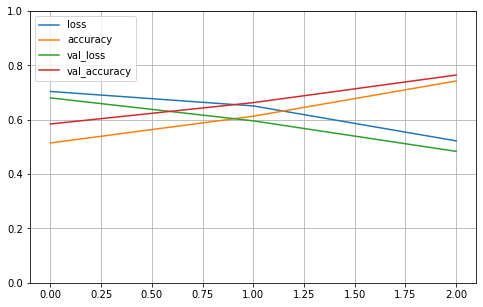

Train set ones/size 2154 / 4175
Compute valiation accuracy
Valid sizes (1044, 4997) (1044,)
Valid set ones/size 521 / 1044
Range of scores: 0.008065325 to 0.9992736
Score threshold 0.5
Prediction set ones/size 445 / 1044


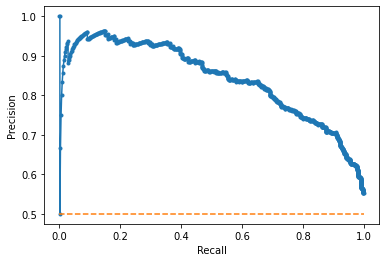

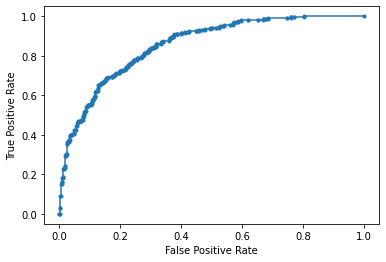

Accuracy: 76.44% Precision: 80.90% Recall: 69.10%
F1: 74.53% AUPRC: 84.14% AUROC: 85.60%
2023-02-06 14:21:33.387545
Fold 2
Model params (mean -1.76, wgt 0.51) (mean -0.80, wgt 0.49)
RCI threshold derived from training set: [-1.28775848]
FIT
2023-02-06 14:21:36.211883
Epoch 1/3
131/131 [==============================] - 2s 14ms/step - loss: 0.7031 - accuracy: 0.5301 - val_loss: 0.6659 - val_accuracy: 0.5948
Epoch 2/3
131/131 [==============================] - 2s 13ms/step - loss: 0.6051 - accuracy: 0.6728 - val_loss: 0.5670 - val_accuracy: 0.7079
Epoch 3/3
131/131 [==============================] - 2s 12ms/step - loss: 0.4757 - accuracy: 0.7722 - val_loss: 0.4985 - val_accuracy: 0.7414
PREDICT
2023-02-06 14:21:47.127768


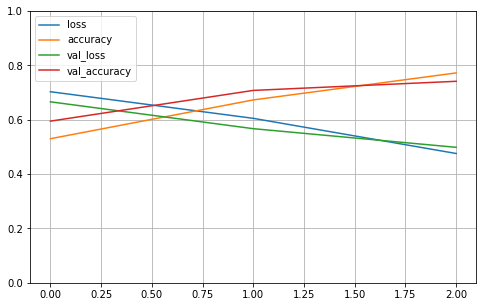

Train set ones/size 2112 / 4175
Compute valiation accuracy
Valid sizes (1044, 4997) (1044,)
Valid set ones/size 506 / 1044
Range of scores: 0.004612446 to 0.9961188
Score threshold 0.5
Prediction set ones/size 526 / 1044


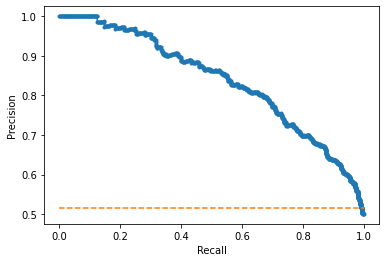

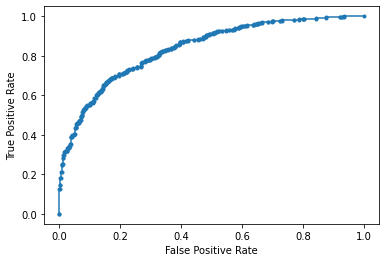

Accuracy: 74.14% Precision: 72.43% Recall: 75.30%
F1: 73.84% AUPRC: 83.78% AUROC: 83.63%
2023-02-06 14:21:47.927642
Fold 3
Model params (mean -1.84, wgt 0.44) (mean -0.88, wgt 0.56)
RCI threshold derived from training set: [-1.3034609]
FIT
2023-02-06 14:21:50.736904
Epoch 1/3
131/131 [==============================] - 2s 14ms/step - loss: 0.7157 - accuracy: 0.5260 - val_loss: 0.6834 - val_accuracy: 0.5603
Epoch 2/3
131/131 [==============================] - 2s 12ms/step - loss: 0.6596 - accuracy: 0.5995 - val_loss: 0.6165 - val_accuracy: 0.6648
Epoch 3/3
131/131 [==============================] - 2s 12ms/step - loss: 0.5396 - accuracy: 0.7262 - val_loss: 0.6124 - val_accuracy: 0.6906
PREDICT
2023-02-06 14:22:01.624655


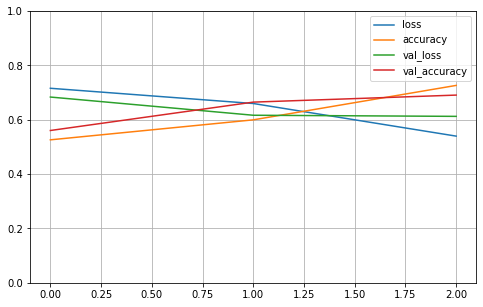

Train set ones/size 2148 / 4175
Compute valiation accuracy
Valid sizes (1044, 4997) (1044,)
Valid set ones/size 527 / 1044
Range of scores: 0.03108274 to 0.9952539
Score threshold 0.5
Prediction set ones/size 786 / 1044


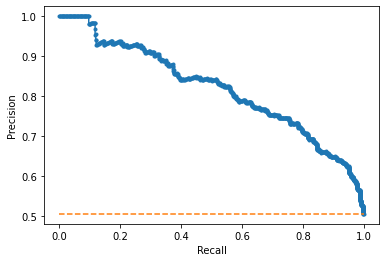

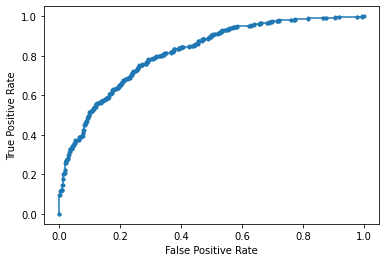

Accuracy: 69.06% Precision: 62.98% Recall: 93.93%
F1: 75.40% AUPRC: 81.98% AUROC: 81.77%
2023-02-06 14:22:02.267174
Fold 4
Model params (mean -0.99, wgt 0.67) (mean -1.95, wgt 0.33)
RCI threshold derived from training set: [-1.30788057]
FIT
2023-02-06 14:22:05.075571
Epoch 1/3
131/131 [==============================] - 2s 14ms/step - loss: 0.7022 - accuracy: 0.5255 - val_loss: 0.6735 - val_accuracy: 0.6006
Epoch 2/3
131/131 [==============================] - 2s 13ms/step - loss: 0.6380 - accuracy: 0.6323 - val_loss: 0.5508 - val_accuracy: 0.7251
Epoch 3/3
131/131 [==============================] - 2s 13ms/step - loss: 0.5149 - accuracy: 0.7451 - val_loss: 0.4613 - val_accuracy: 0.7807
PREDICT
2023-02-06 14:22:10.919606


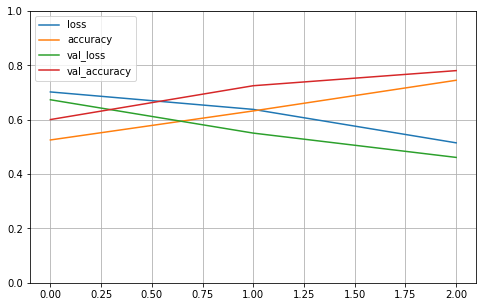

Train set ones/size 2137 / 4175
Compute valiation accuracy
Valid sizes (1044, 4997) (1044,)
Valid set ones/size 538 / 1044
Range of scores: 0.0144271515 to 0.9946801
Score threshold 0.5
Prediction set ones/size 527 / 1044


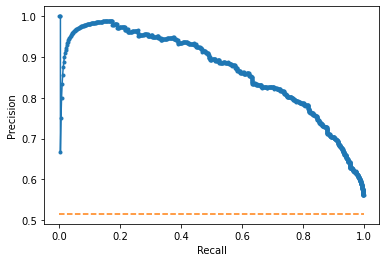

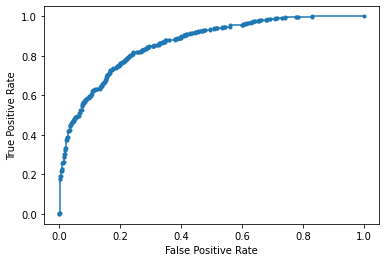

Accuracy: 78.07% Precision: 79.32% Recall: 77.70%
F1: 78.50% AUPRC: 86.77% AUROC: 86.41%
2023-02-06 14:22:11.571703
Fold 5
Model params (mean -1.02, wgt 0.66) (mean -1.94, wgt 0.34)
RCI threshold derived from training set: [-1.32590026]
FIT
2023-02-06 14:22:14.371227
Epoch 1/3
131/131 [==============================] - 2s 14ms/step - loss: 0.7016 - accuracy: 0.5292 - val_loss: 0.6720 - val_accuracy: 0.5849
Epoch 2/3
131/131 [==============================] - 2s 12ms/step - loss: 0.6351 - accuracy: 0.6468 - val_loss: 0.5397 - val_accuracy: 0.7344
Epoch 3/3
131/131 [==============================] - 2s 13ms/step - loss: 0.4917 - accuracy: 0.7641 - val_loss: 0.4828 - val_accuracy: 0.7622
PREDICT
2023-02-06 14:22:25.251574


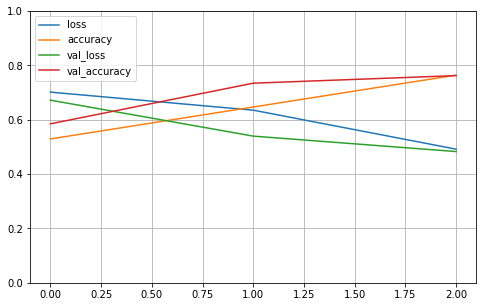

Train set ones/size 2108 / 4176
Compute valiation accuracy
Valid sizes (1043, 4997) (1043,)
Valid set ones/size 572 / 1043
Range of scores: 0.00345929 to 0.99365634
Score threshold 0.5
Prediction set ones/size 642 / 1043


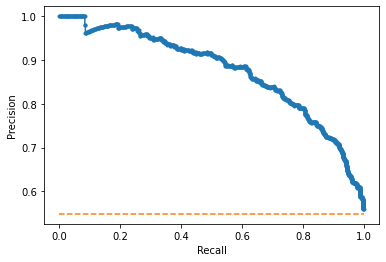

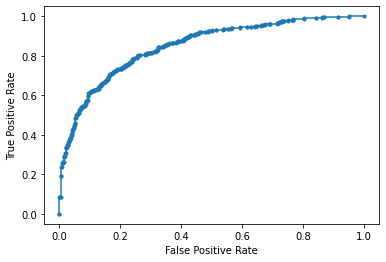

Accuracy: 76.22% Precision: 75.23% Recall: 84.44%
F1: 79.57% AUPRC: 87.56% AUROC: 85.00%
2023-02-06 14:22:25.885445

Completed cross validation 5 folds 3 epochs
 accuracy mean 74.78% +/- 3.12
 precision mean 74.17% +/- 6.34
 recall mean 80.09% +/- 8.48
 F1 mean 76.37% +/- 2.26
 AUPRC mean 84.85% +/- 2.04
 AUROC mean 84.48% +/- 1.63
Finished cell Line 7 NCI.H460

2023-02-06 14:22:27.168270
Start cell Line 8 NHEK
Number of RCI values loaded 1080
Num RCI: 1080
Load sequence...
Cross validation...
2023-02-06 14:22:37.661594
splitting
Fold 1
Model params (mean 0.51, wgt 0.49) (mean -1.74, wgt 0.51)
RCI threshold derived from training set: [-0.64607643]
FIT
2023-02-06 14:22:40.393715
Epoch 1/3
204/204 [==============================] - 3s 14ms/step - loss: 0.6924 - accuracy: 0.5417 - val_loss: 0.6647 - val_accuracy: 0.6159
Epoch 2/3
204/204 [==============================] - 3s 13ms/step - loss: 0.6259 - accuracy: 0.6457 - val_loss: 0.5821 - val_accuracy: 0.6785
Epoch 3/3
204/204 [==========

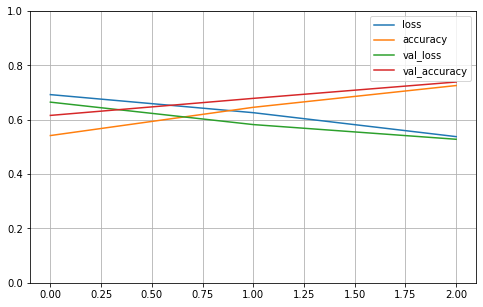

Train set ones/size 3309 / 6505
Compute valiation accuracy
Valid sizes (1627, 4997) (1627,)
Valid set ones/size 849 / 1627
Range of scores: 0.004207663 to 0.993985
Score threshold 0.5
Prediction set ones/size 868 / 1627


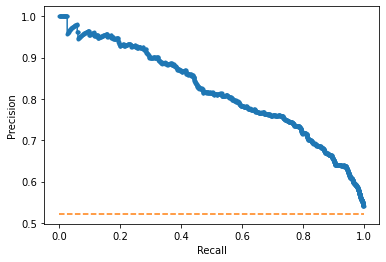

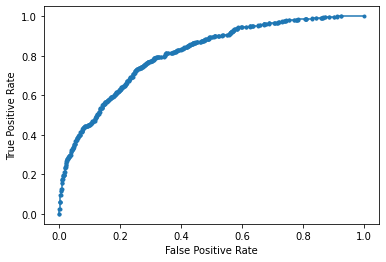

Accuracy: 73.88% Precision: 74.42% Recall: 76.09%
F1: 75.25% AUPRC: 81.94% AUROC: 80.96%
2023-02-06 14:22:52.108229
Fold 2
Model params (mean 0.50, wgt 0.50) (mean -1.79, wgt 0.50)
RCI threshold derived from training set: [-0.64683388]
FIT
2023-02-06 14:22:56.158883
Epoch 1/3
204/204 [==============================] - 3s 14ms/step - loss: 0.6797 - accuracy: 0.5676 - val_loss: 0.6384 - val_accuracy: 0.6368
Epoch 2/3
204/204 [==============================] - 3s 13ms/step - loss: 0.5954 - accuracy: 0.6792 - val_loss: 0.5664 - val_accuracy: 0.6951
Epoch 3/3
204/204 [==============================] - 3s 13ms/step - loss: 0.5061 - accuracy: 0.7565 - val_loss: 0.5383 - val_accuracy: 0.7222
PREDICT
2023-02-06 14:23:07.086026


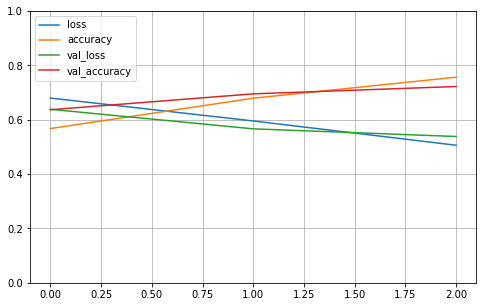

Train set ones/size 3330 / 6505
Compute valiation accuracy
Valid sizes (1627, 4997) (1627,)
Valid set ones/size 828 / 1627
Range of scores: 0.0068712835 to 0.99711704
Score threshold 0.5
Prediction set ones/size 968 / 1627


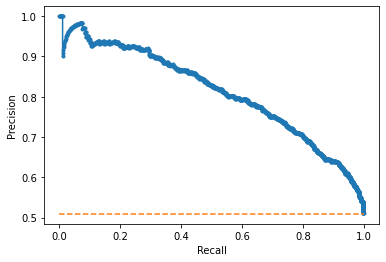

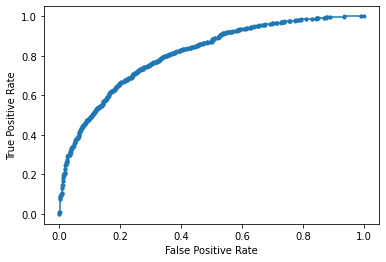

Accuracy: 72.22% Precision: 69.42% Recall: 81.16%
F1: 74.83% AUPRC: 81.32% AUROC: 80.94%
2023-02-06 14:23:07.838474
Fold 3
Model params (mean 0.50, wgt 0.50) (mean -1.80, wgt 0.50)
RCI threshold derived from training set: [-0.64279568]
FIT
2023-02-06 14:23:13.145752
Epoch 1/3
204/204 [==============================] - 3s 14ms/step - loss: 0.6897 - accuracy: 0.5392 - val_loss: 0.6411 - val_accuracy: 0.6310
Epoch 2/3
204/204 [==============================] - 3s 13ms/step - loss: 0.6052 - accuracy: 0.6720 - val_loss: 0.5977 - val_accuracy: 0.6747
Epoch 3/3
204/204 [==============================] - 3s 12ms/step - loss: 0.5068 - accuracy: 0.7499 - val_loss: 0.5568 - val_accuracy: 0.7183
PREDICT
2023-02-06 14:23:24.125784


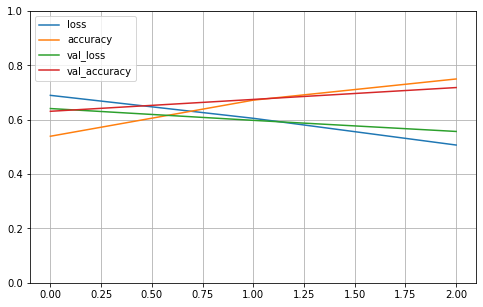

Train set ones/size 3315 / 6506
Compute valiation accuracy
Valid sizes (1626, 4997) (1626,)
Valid set ones/size 825 / 1626
Range of scores: 0.005731643 to 0.9963671
Score threshold 0.5
Prediction set ones/size 1031 / 1626


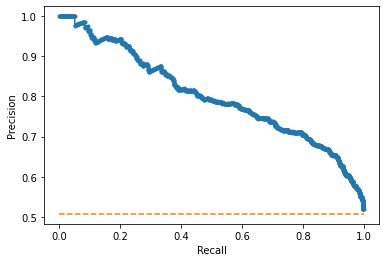

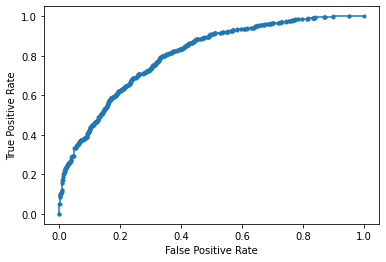

Accuracy: 71.83% Precision: 67.80% Recall: 84.73%
F1: 75.32% AUPRC: 80.23% AUROC: 80.26%
2023-02-06 14:23:24.881368
Fold 4
Model params (mean -1.82, wgt 0.49) (mean 0.45, wgt 0.51)
RCI threshold derived from training set: [-0.6600788]
FIT
2023-02-06 14:23:28.721198
Epoch 1/3
204/204 [==============================] - 3s 13ms/step - loss: 0.6880 - accuracy: 0.5384 - val_loss: 0.6385 - val_accuracy: 0.6396
Epoch 2/3
204/204 [==============================] - 3s 13ms/step - loss: 0.6052 - accuracy: 0.6706 - val_loss: 0.5922 - val_accuracy: 0.6845
Epoch 3/3
204/204 [==============================] - 3s 13ms/step - loss: 0.5258 - accuracy: 0.7353 - val_loss: 0.4962 - val_accuracy: 0.7601
PREDICT
2023-02-06 14:23:39.638139


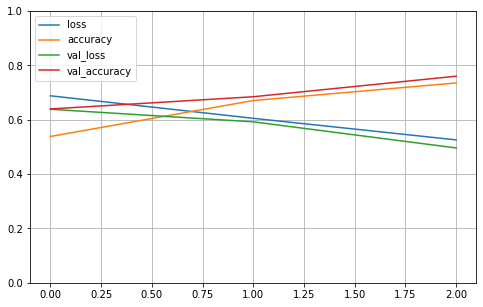

Train set ones/size 3322 / 6506
Compute valiation accuracy
Valid sizes (1626, 4997) (1626,)
Valid set ones/size 844 / 1626
Range of scores: 0.0056684404 to 0.9913509
Score threshold 0.5
Prediction set ones/size 812 / 1626


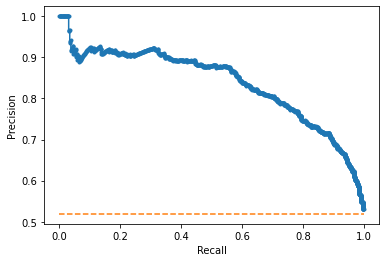

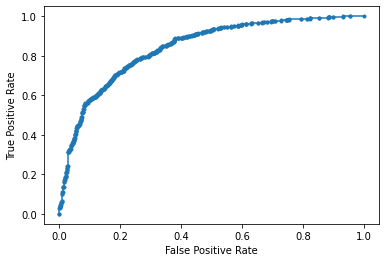

Accuracy: 76.01% Precision: 77.96% Recall: 75.00%
F1: 76.45% AUPRC: 83.82% AUROC: 84.19%
2023-02-06 14:23:40.454634
Fold 5
Model params (mean 0.41, wgt 0.53) (mean -1.83, wgt 0.47)
RCI threshold derived from training set: [-0.64465368]
FIT
2023-02-06 14:23:44.264168
Epoch 1/3
204/204 [==============================] - 3s 14ms/step - loss: 0.6941 - accuracy: 0.5460 - val_loss: 0.6447 - val_accuracy: 0.6365
Epoch 2/3
204/204 [==============================] - 3s 13ms/step - loss: 0.6087 - accuracy: 0.6689 - val_loss: 0.5698 - val_accuracy: 0.6993
Epoch 3/3
204/204 [==============================] - 3s 13ms/step - loss: 0.5235 - accuracy: 0.7435 - val_loss: 0.5318 - val_accuracy: 0.7362
PREDICT
2023-02-06 14:23:55.160583


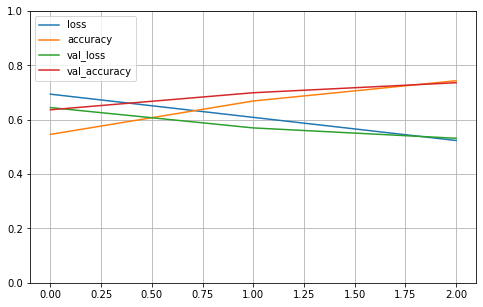

Train set ones/size 3333 / 6506
Compute valiation accuracy
Valid sizes (1626, 4997) (1626,)
Valid set ones/size 809 / 1626
Range of scores: 0.008250201 to 0.97860754
Score threshold 0.5
Prediction set ones/size 882 / 1626


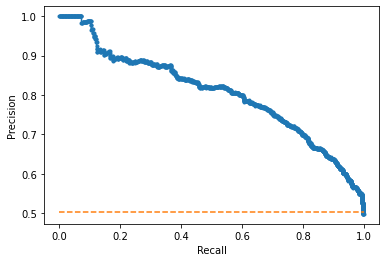

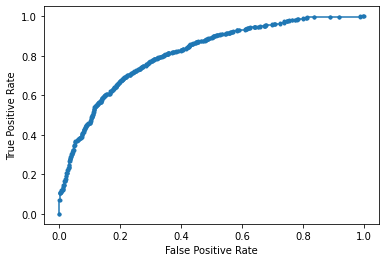

Accuracy: 73.62% Precision: 71.54% Recall: 78.00%
F1: 74.63% AUPRC: 80.59% AUROC: 81.13%
2023-02-06 14:23:55.890978

Completed cross validation 5 folds 3 epochs
 accuracy mean 73.51% +/- 1.48
 precision mean 72.23% +/- 3.62
 recall mean 78.99% +/- 3.55
 F1 mean 75.30% +/- 0.63
 AUPRC mean 81.58% +/- 1.27
 AUROC mean 81.50% +/- 1.38
Finished cell Line 8 NHEK

2023-02-06 14:23:57.258746
Start cell Line 9 SK.MEL.5
Number of RCI values loaded 534
Num RCI: 534
Load sequence...
Cross validation...
2023-02-06 14:24:03.970924
splitting
Fold 1
Model params (mean -0.90, wgt 0.58) (mean -2.58, wgt 0.42)
RCI threshold derived from training set: [-1.60509638]
FIT
2023-02-06 14:24:05.520329
Epoch 1/3
129/129 [==============================] - 2s 15ms/step - loss: 0.7009 - accuracy: 0.5360 - val_loss: 0.6792 - val_accuracy: 0.6070
Epoch 2/3
129/129 [==============================] - 2s 12ms/step - loss: 0.6517 - accuracy: 0.6250 - val_loss: 0.5900 - val_accuracy: 0.6761
Epoch 3/3
129/129 [===========

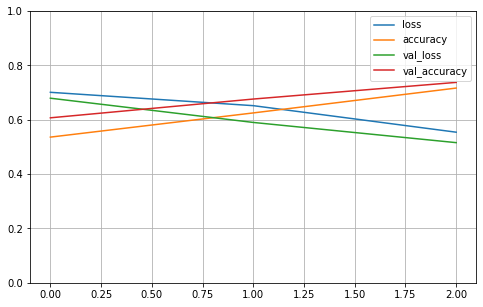

Train set ones/size 2154 / 4112
Compute valiation accuracy
Valid sizes (1028, 4997) (1028,)
Valid set ones/size 539 / 1028
Range of scores: 0.00937246 to 0.99396354
Score threshold 0.5
Prediction set ones/size 563 / 1028


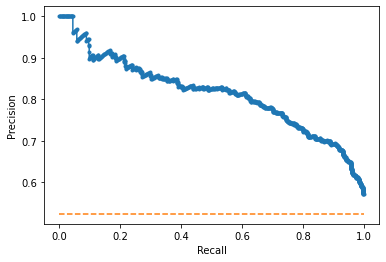

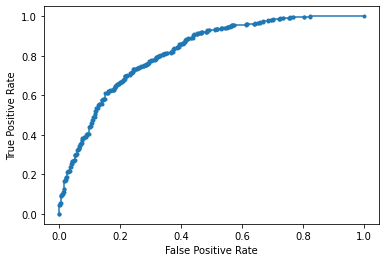

Accuracy: 73.74% Precision: 73.89% Recall: 77.18%
F1: 75.50% AUPRC: 81.44% AUROC: 81.98%
2023-02-06 14:24:11.905514
Fold 2
Model params (mean -0.88, wgt 0.60) (mean -2.67, wgt 0.40)
RCI threshold derived from training set: [-1.60326484]
FIT
2023-02-06 14:24:14.640594
Epoch 1/3
129/129 [==============================] - 2s 14ms/step - loss: 0.6955 - accuracy: 0.5460 - val_loss: 0.6599 - val_accuracy: 0.6158
Epoch 2/3
129/129 [==============================] - 2s 13ms/step - loss: 0.6129 - accuracy: 0.6547 - val_loss: 0.5772 - val_accuracy: 0.6868
Epoch 3/3
129/129 [==============================] - 2s 13ms/step - loss: 0.4905 - accuracy: 0.7641 - val_loss: 0.4806 - val_accuracy: 0.7714
PREDICT
2023-02-06 14:24:25.515565


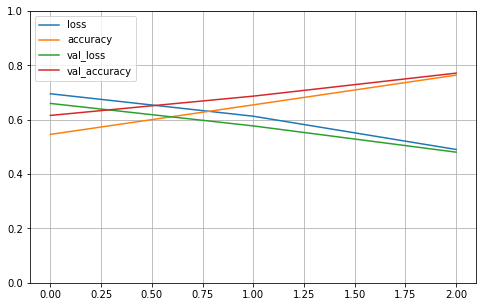

Train set ones/size 2162 / 4112
Compute valiation accuracy
Valid sizes (1028, 4997) (1028,)
Valid set ones/size 531 / 1028
Range of scores: 0.0029911762 to 0.9945305
Score threshold 0.5
Prediction set ones/size 574 / 1028


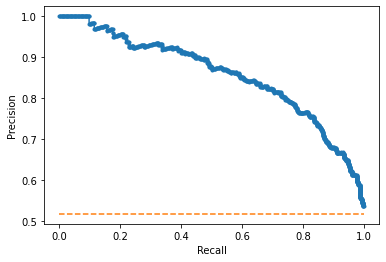

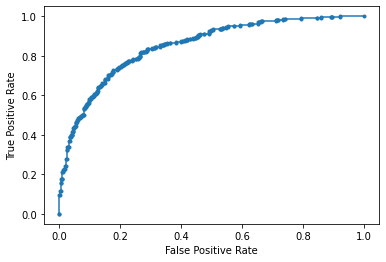

Accuracy: 77.14% Precision: 75.78% Recall: 81.92%
F1: 78.73% AUPRC: 85.78% AUROC: 85.00%
2023-02-06 14:24:26.313108
Fold 3
Model params (mean -2.60, wgt 0.42) (mean -0.89, wgt 0.58)
RCI threshold derived from training set: [-1.61365343]
FIT
2023-02-06 14:24:29.083602
Epoch 1/3
129/129 [==============================] - 2s 15ms/step - loss: 0.6927 - accuracy: 0.5482 - val_loss: 0.7023 - val_accuracy: 0.5652
Epoch 2/3
129/129 [==============================] - 2s 13ms/step - loss: 0.6272 - accuracy: 0.6462 - val_loss: 0.5694 - val_accuracy: 0.7014
Epoch 3/3
129/129 [==============================] - 2s 13ms/step - loss: 0.5041 - accuracy: 0.7485 - val_loss: 0.5074 - val_accuracy: 0.7374
PREDICT
2023-02-06 14:24:39.965402


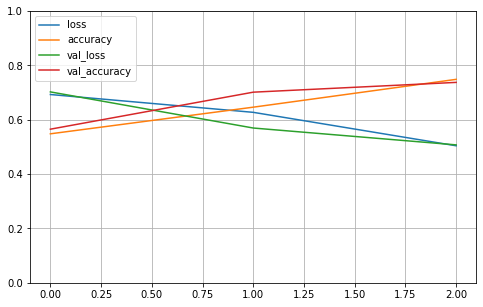

Train set ones/size 2158 / 4112
Compute valiation accuracy
Valid sizes (1028, 4997) (1028,)
Valid set ones/size 545 / 1028
Range of scores: 0.0030819762 to 0.97910976
Score threshold 0.5
Prediction set ones/size 519 / 1028


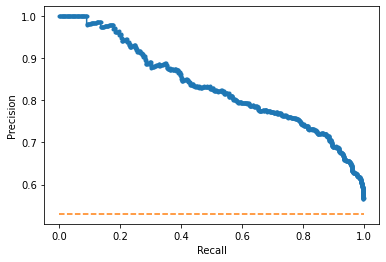

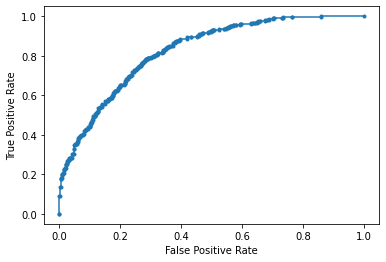

Accuracy: 73.74% Precision: 76.49% Recall: 72.84%
F1: 74.62% AUPRC: 83.40% AUROC: 82.48%
2023-02-06 14:24:40.609172
Fold 4
Model params (mean -0.89, wgt 0.60) (mean -2.73, wgt 0.40)
RCI threshold derived from training set: [-1.63034149]
FIT
2023-02-06 14:24:43.319129
Epoch 1/3
129/129 [==============================] - 2s 14ms/step - loss: 0.6951 - accuracy: 0.5564 - val_loss: 0.6777 - val_accuracy: 0.5817
Epoch 2/3
129/129 [==============================] - 2s 13ms/step - loss: 0.6326 - accuracy: 0.6411 - val_loss: 0.5850 - val_accuracy: 0.6868
Epoch 3/3
129/129 [==============================] - 2s 12ms/step - loss: 0.5302 - accuracy: 0.7347 - val_loss: 0.5623 - val_accuracy: 0.7043
PREDICT
2023-02-06 14:24:49.030271


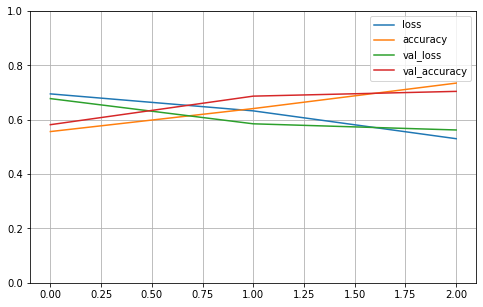

Train set ones/size 2160 / 4112
Compute valiation accuracy
Valid sizes (1028, 4997) (1028,)
Valid set ones/size 543 / 1028
Range of scores: 0.0032472706 to 0.995758
Score threshold 0.5
Prediction set ones/size 547 / 1028


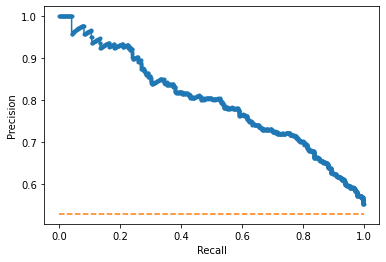

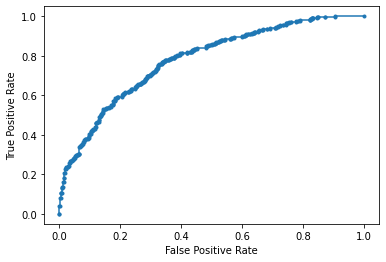

Accuracy: 70.43% Precision: 71.85% Recall: 72.38%
F1: 72.11% AUPRC: 79.63% AUROC: 77.90%
2023-02-06 14:24:49.682717
Fold 5
Model params (mean -0.88, wgt 0.57) (mean -2.56, wgt 0.43)
RCI threshold derived from training set: [-1.60380221]
FIT
2023-02-06 14:24:52.430387
Epoch 1/3
129/129 [==============================] - 2s 14ms/step - loss: 0.7097 - accuracy: 0.5221 - val_loss: 0.6975 - val_accuracy: 0.5292
Epoch 2/3
129/129 [==============================] - 2s 13ms/step - loss: 0.6583 - accuracy: 0.5997 - val_loss: 0.6357 - val_accuracy: 0.6362
Epoch 3/3
129/129 [==============================] - 2s 13ms/step - loss: 0.5738 - accuracy: 0.7108 - val_loss: 0.5474 - val_accuracy: 0.7160
PREDICT
2023-02-06 14:24:58.188933


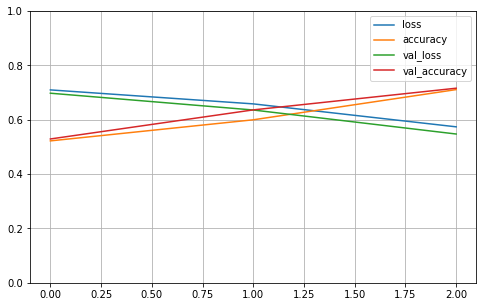

Train set ones/size 2154 / 4112
Compute valiation accuracy
Valid sizes (1028, 4997) (1028,)
Valid set ones/size 539 / 1028
Range of scores: 0.021289844 to 0.9866338
Score threshold 0.5
Prediction set ones/size 595 / 1028


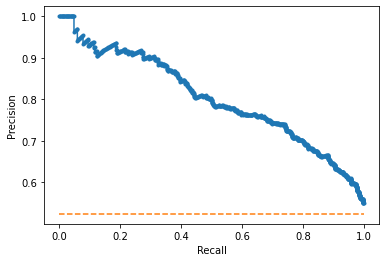

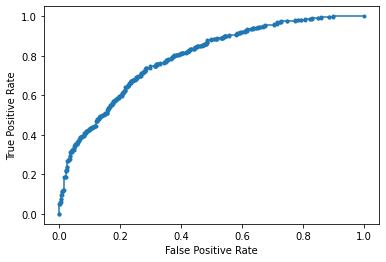

Accuracy: 71.60% Precision: 70.76% Recall: 78.11%
F1: 74.25% AUPRC: 80.39% AUROC: 79.26%
2023-02-06 14:24:58.859719

Completed cross validation 5 folds 3 epochs
 accuracy mean 73.33% +/- 2.29
 precision mean 73.75% +/- 2.20
 recall mean 76.49% +/- 3.54
 F1 mean 75.04% +/- 2.16
 AUPRC mean 82.13% +/- 2.22
 AUROC mean 81.32% +/- 2.50
Finished cell Line 9 SK.MEL.5

2023-02-06 14:25:00.167440
Start cell Line 10 SK.N.DZ
Number of RCI values loaded 603
Num RCI: 603
Load sequence...
Cross validation...
2023-02-06 14:25:07.936597
splitting
Fold 1
Model params (mean -0.20, wgt 0.64) (mean -1.39, wgt 0.36)
RCI threshold derived from training set: [-0.62536139]
FIT
2023-02-06 14:25:10.093667
Epoch 1/3
145/145 [==============================] - 3s 15ms/step - loss: 0.6861 - accuracy: 0.5722 - val_loss: 0.6425 - val_accuracy: 0.6216
Epoch 2/3
145/145 [==============================] - 2s 13ms/step - loss: 0.6036 - accuracy: 0.6833 - val_loss: 0.6059 - val_accuracy: 0.6597
Epoch 3/3
145/145 [=======

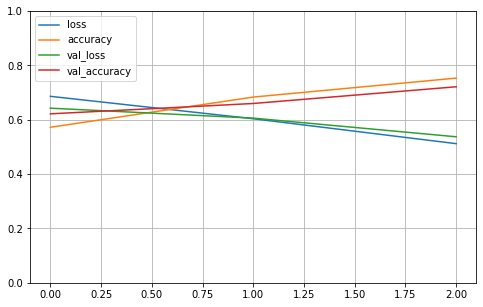

Train set ones/size 2647 / 4617
Compute valiation accuracy
Valid sizes (1155, 4997) (1155,)
Valid set ones/size 658 / 1155
Range of scores: 0.050839387 to 0.9970866
Score threshold 0.5
Prediction set ones/size 896 / 1155


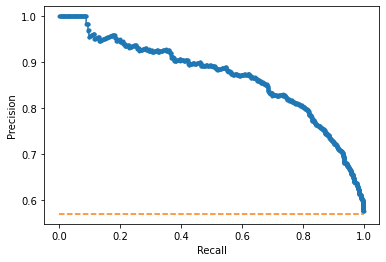

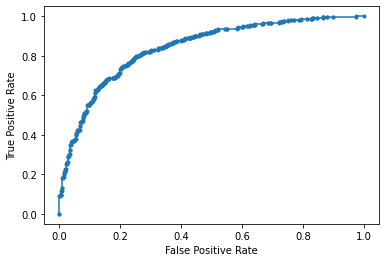

Accuracy: 72.12% Precision: 68.75% Recall: 93.62%
F1: 79.28% AUPRC: 86.91% AUROC: 84.11%
2023-02-06 14:25:21.803877
Fold 2
Model params (mean -0.20, wgt 0.64) (mean -1.36, wgt 0.36)
RCI threshold derived from training set: [-0.61271748]
FIT
2023-02-06 14:25:25.155369
Epoch 1/3
145/145 [==============================] - 3s 14ms/step - loss: 0.6865 - accuracy: 0.5625 - val_loss: 0.6742 - val_accuracy: 0.5740
Epoch 2/3
145/145 [==============================] - 2s 13ms/step - loss: 0.6221 - accuracy: 0.6576 - val_loss: 0.5783 - val_accuracy: 0.6814
Epoch 3/3
145/145 [==============================] - 2s 13ms/step - loss: 0.4957 - accuracy: 0.7600 - val_loss: 0.4793 - val_accuracy: 0.7758
PREDICT
2023-02-06 14:25:36.023527


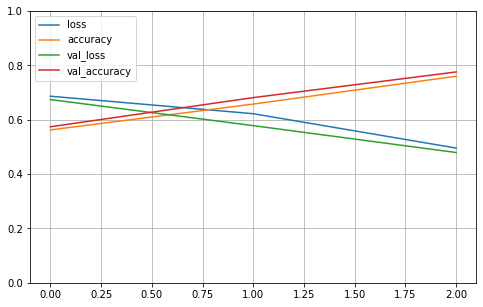

Train set ones/size 2635 / 4617
Compute valiation accuracy
Valid sizes (1155, 4997) (1155,)
Valid set ones/size 657 / 1155
Range of scores: 0.009484593 to 0.99320763
Score threshold 0.5
Prediction set ones/size 628 / 1155


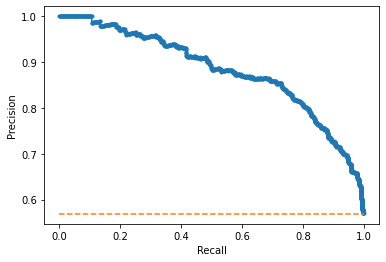

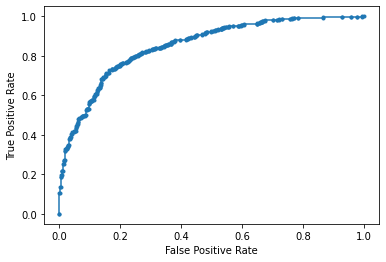

Accuracy: 77.58% Precision: 81.69% Recall: 78.08%
F1: 79.84% AUPRC: 88.23% AUROC: 85.14%
2023-02-06 14:25:36.713939
Fold 3
Model params (mean -0.19, wgt 0.65) (mean -1.36, wgt 0.35)
RCI threshold derived from training set: [-0.60483226]
FIT
2023-02-06 14:25:40.206069
Epoch 1/3
145/145 [==============================] - 3s 14ms/step - loss: 0.6750 - accuracy: 0.5886 - val_loss: 0.6493 - val_accuracy: 0.6205
Epoch 2/3
145/145 [==============================] - 2s 12ms/step - loss: 0.5959 - accuracy: 0.6860 - val_loss: 0.5550 - val_accuracy: 0.7288
Epoch 3/3
145/145 [==============================] - 2s 12ms/step - loss: 0.4884 - accuracy: 0.7670 - val_loss: 0.5061 - val_accuracy: 0.7565
PREDICT
2023-02-06 14:25:51.061411


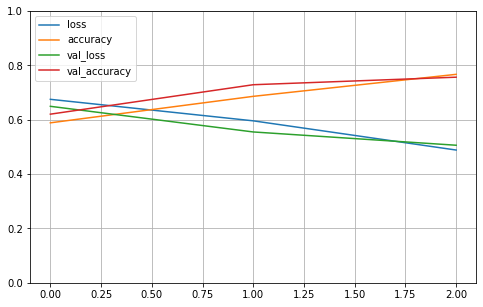

Train set ones/size 2660 / 4618
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 632 / 1154
Range of scores: 0.017112004 to 0.9996432
Score threshold 0.5
Prediction set ones/size 805 / 1154


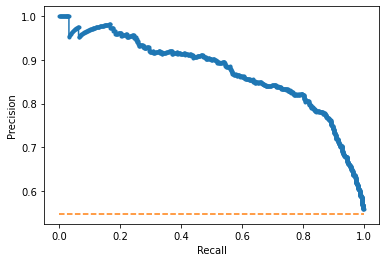

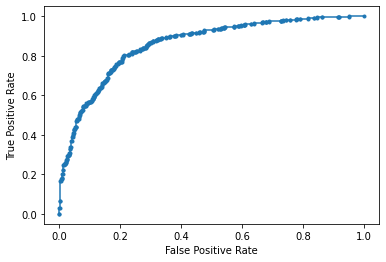

Accuracy: 75.65% Precision: 71.80% Recall: 91.46%
F1: 80.45% AUPRC: 87.26% AUROC: 85.78%
2023-02-06 14:25:51.734241
Fold 4
Model params (mean -0.35, wgt 0.80) (mean -1.77, wgt 0.20)
RCI threshold derived from training set: [-0.63127586]
FIT
2023-02-06 14:25:54.954722
Epoch 1/3
145/145 [==============================] - 3s 15ms/step - loss: 0.6772 - accuracy: 0.5829 - val_loss: 0.6169 - val_accuracy: 0.6898
Epoch 2/3
145/145 [==============================] - 2s 14ms/step - loss: 0.5830 - accuracy: 0.6903 - val_loss: 0.5208 - val_accuracy: 0.7478
Epoch 3/3
145/145 [==============================] - 2s 13ms/step - loss: 0.4698 - accuracy: 0.7835 - val_loss: 0.4751 - val_accuracy: 0.7773
PREDICT
2023-02-06 14:26:05.820248


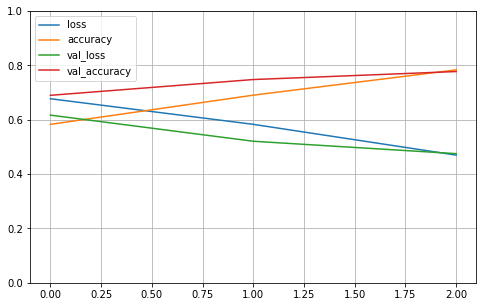

Train set ones/size 2633 / 4618
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 676 / 1154
Range of scores: 0.0047434797 to 0.99932396
Score threshold 0.5
Prediction set ones/size 793 / 1154


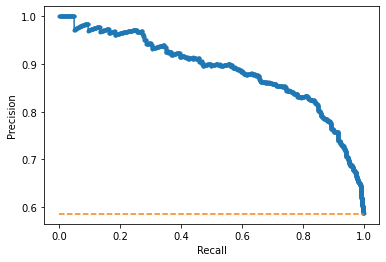

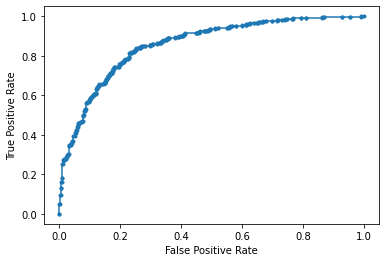

Accuracy: 77.73% Precision: 76.42% Recall: 89.64%
F1: 82.51% AUPRC: 88.72% AUROC: 85.63%
2023-02-06 14:26:06.623170
Fold 5
Model params (mean -1.74, wgt 0.22) (mean -0.30, wgt 0.78)
RCI threshold derived from training set: [-0.62153937]
FIT
2023-02-06 14:26:10.008216
Epoch 1/3
145/145 [==============================] - 3s 15ms/step - loss: 0.6828 - accuracy: 0.5678 - val_loss: 0.6488 - val_accuracy: 0.5953
Epoch 2/3
145/145 [==============================] - 2s 13ms/step - loss: 0.6126 - accuracy: 0.6665 - val_loss: 0.5960 - val_accuracy: 0.6551
Epoch 3/3
145/145 [==============================] - 2s 12ms/step - loss: 0.4975 - accuracy: 0.7599 - val_loss: 0.4723 - val_accuracy: 0.7773
PREDICT
2023-02-06 14:26:20.870717


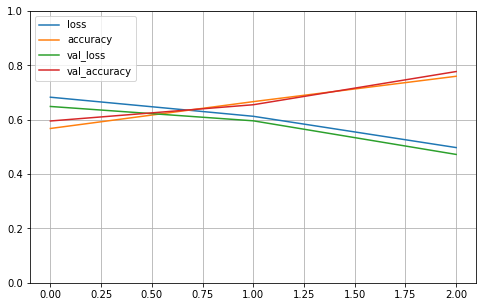

Train set ones/size 2629 / 4618
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 675 / 1154
Range of scores: 0.008586366 to 0.99655175
Score threshold 0.5
Prediction set ones/size 806 / 1154


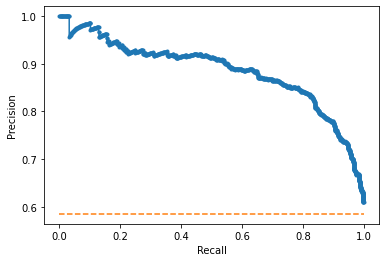

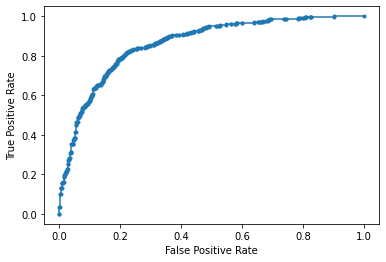

Accuracy: 77.73% Precision: 75.93% Recall: 90.67%
F1: 82.65% AUPRC: 88.54% AUROC: 86.20%
2023-02-06 14:26:21.682343

Completed cross validation 5 folds 3 epochs
 accuracy mean 76.16% +/- 2.17
 precision mean 74.92% +/- 4.40
 recall mean 88.69% +/- 5.46
 F1 mean 80.94% +/- 1.38
 AUPRC mean 87.93% +/- 0.72
 AUROC mean 85.37% +/- 0.72
Finished cell Line 10 SK.N.DZ

2023-02-06 14:26:22.989757
Start cell Line 11 SK.N.SH
Number of RCI values loaded 1647
Num RCI: 1647
Load sequence...
Cross validation...
2023-02-06 14:26:36.727075
splitting
Fold 1
Model params (mean -0.15, wgt 0.53) (mean -1.88, wgt 0.47)
RCI threshold derived from training set: [-0.96527378]
FIT
2023-02-06 14:26:39.730885
Epoch 1/3
259/259 [==============================] - 4s 14ms/step - loss: 0.6834 - accuracy: 0.5565 - val_loss: 0.6566 - val_accuracy: 0.5982
Epoch 2/3
259/259 [==============================] - 3s 12ms/step - loss: 0.6206 - accuracy: 0.6483 - val_loss: 0.5951 - val_accuracy: 0.6630
Epoch 3/3
259/259 [=====

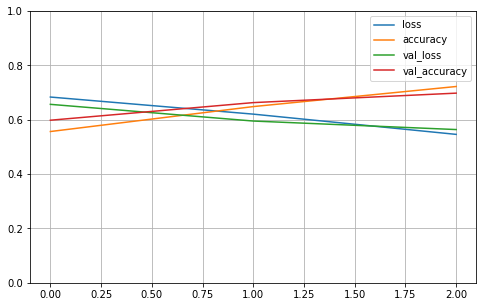

Train set ones/size 4304 / 8269
Compute valiation accuracy
Valid sizes (2068, 4997) (2068,)
Valid set ones/size 1072 / 2068
Range of scores: 0.00985296 to 0.99887997
Score threshold 0.5
Prediction set ones/size 1365 / 2068


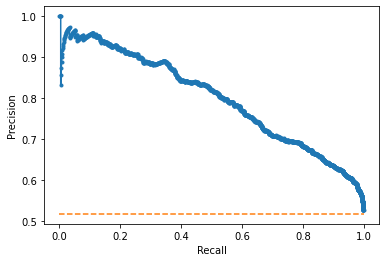

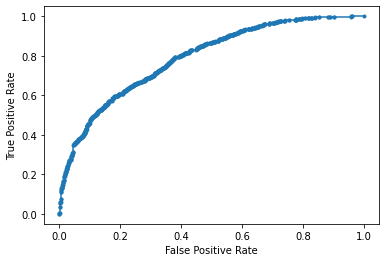

Accuracy: 69.78% Precision: 66.37% Recall: 84.51%
F1: 74.35% AUPRC: 80.03% AUROC: 79.09%
2023-02-06 14:26:51.146687
Fold 2
Model params (mean -0.11, wgt 0.52) (mean -1.88, wgt 0.48)
RCI threshold derived from training set: [-0.96386639]
FIT
2023-02-06 14:26:55.882631
Epoch 1/3
259/259 [==============================] - 4s 14ms/step - loss: 0.6944 - accuracy: 0.5351 - val_loss: 0.6559 - val_accuracy: 0.6083
Epoch 2/3
259/259 [==============================] - 3s 13ms/step - loss: 0.6394 - accuracy: 0.6285 - val_loss: 0.6022 - val_accuracy: 0.6692
Epoch 3/3
259/259 [==============================] - 3s 13ms/step - loss: 0.5668 - accuracy: 0.7043 - val_loss: 0.5389 - val_accuracy: 0.7273
PREDICT
2023-02-06 14:27:06.659624


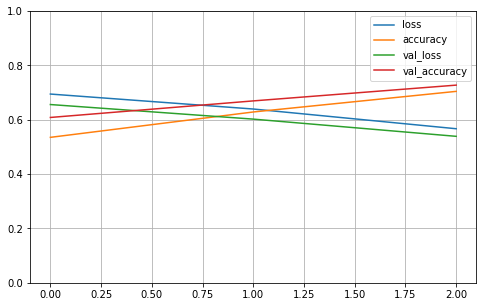

Train set ones/size 4258 / 8269
Compute valiation accuracy
Valid sizes (2068, 4997) (2068,)
Valid set ones/size 1117 / 2068
Range of scores: 0.004020469 to 0.98982775
Score threshold 0.5
Prediction set ones/size 1045 / 2068


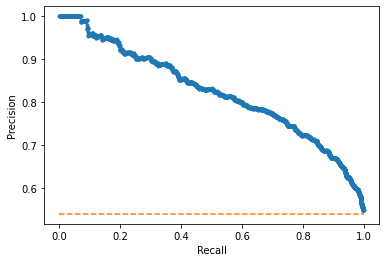

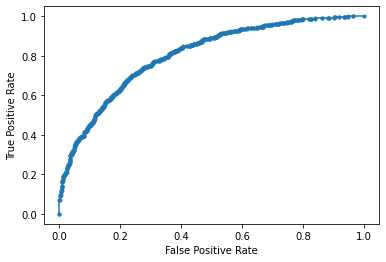

Accuracy: 72.73% Precision: 76.46% Recall: 71.53%
F1: 73.91% AUPRC: 82.47% AUROC: 80.40%
2023-02-06 14:27:07.420316
Fold 3
Model params (mean -0.12, wgt 0.52) (mean -1.90, wgt 0.48)
RCI threshold derived from training set: [-0.96594014]
FIT
2023-02-06 14:27:12.027257
Epoch 1/3
259/259 [==============================] - 4s 14ms/step - loss: 0.6874 - accuracy: 0.5538 - val_loss: 0.6504 - val_accuracy: 0.6197
Epoch 2/3
259/259 [==============================] - 3s 12ms/step - loss: 0.6216 - accuracy: 0.6514 - val_loss: 0.5888 - val_accuracy: 0.6913
Epoch 3/3
259/259 [==============================] - 3s 12ms/step - loss: 0.5523 - accuracy: 0.7219 - val_loss: 0.5786 - val_accuracy: 0.6971
PREDICT
2023-02-06 14:27:22.731215


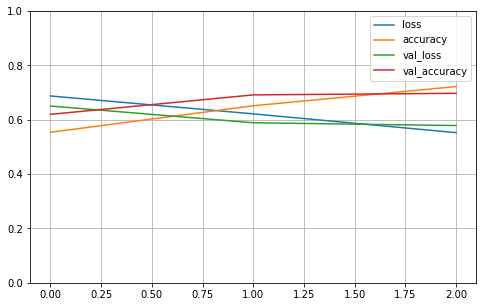

Train set ones/size 4286 / 8270
Compute valiation accuracy
Valid sizes (2067, 4997) (2067,)
Valid set ones/size 1090 / 2067
Range of scores: 6.340515e-05 to 0.98032963
Score threshold 0.5
Prediction set ones/size 892 / 2067


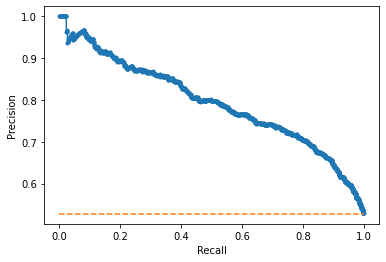

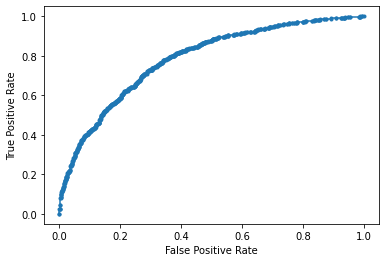

Accuracy: 69.71% Precision: 76.01% Recall: 62.20%
F1: 68.42% AUPRC: 79.43% AUROC: 78.34%
2023-02-06 14:27:23.557528
Fold 4
Model params (mean -0.15, wgt 0.54) (mean -1.86, wgt 0.46)
RCI threshold derived from training set: [-0.94596663]
FIT
2023-02-06 14:27:28.179081
Epoch 1/3
259/259 [==============================] - 4s 13ms/step - loss: 0.6934 - accuracy: 0.5305 - val_loss: 0.6754 - val_accuracy: 0.5568
Epoch 2/3
259/259 [==============================] - 3s 12ms/step - loss: 0.6314 - accuracy: 0.6458 - val_loss: 0.5955 - val_accuracy: 0.6870
Epoch 3/3
259/259 [==============================] - 3s 12ms/step - loss: 0.5563 - accuracy: 0.7184 - val_loss: 0.5753 - val_accuracy: 0.6904
PREDICT
2023-02-06 14:27:39.148415


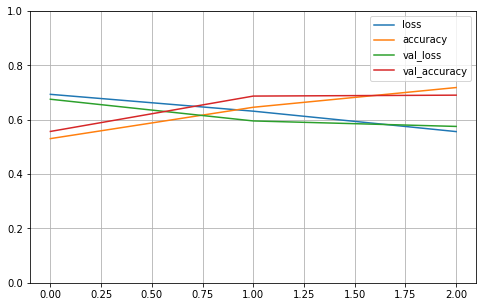

Train set ones/size 4275 / 8270
Compute valiation accuracy
Valid sizes (2067, 4997) (2067,)
Valid set ones/size 1041 / 2067
Range of scores: 0.014800578 to 0.9874571
Score threshold 0.5
Prediction set ones/size 857 / 2067


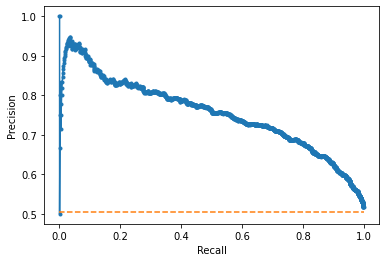

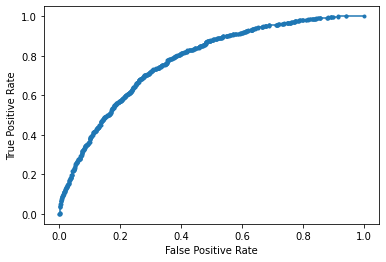

Accuracy: 69.04% Precision: 73.40% Recall: 60.42%
F1: 66.28% AUPRC: 75.49% AUROC: 77.54%
2023-02-06 14:27:39.912876
Fold 5
Model params (mean -0.13, wgt 0.53) (mean -1.88, wgt 0.47)
RCI threshold derived from training set: [-0.94505213]
FIT
2023-02-06 14:27:44.244217
Epoch 1/3
259/259 [==============================] - 4s 13ms/step - loss: 0.6987 - accuracy: 0.5374 - val_loss: 0.6622 - val_accuracy: 0.5960
Epoch 2/3
259/259 [==============================] - 3s 12ms/step - loss: 0.6309 - accuracy: 0.6478 - val_loss: 0.6085 - val_accuracy: 0.6628
Epoch 3/3
259/259 [==============================] - 3s 13ms/step - loss: 0.5578 - accuracy: 0.7097 - val_loss: 0.5934 - val_accuracy: 0.6870
PREDICT
2023-02-06 14:27:55.172991


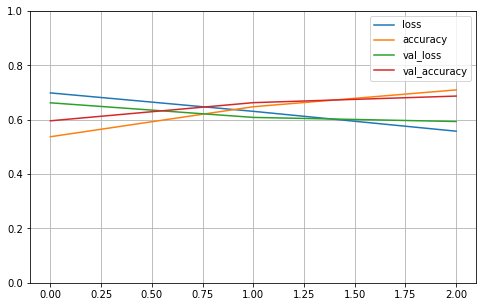

Train set ones/size 4279 / 8270
Compute valiation accuracy
Valid sizes (2067, 4997) (2067,)
Valid set ones/size 1037 / 2067
Range of scores: 0.015722943 to 0.9906908
Score threshold 0.5
Prediction set ones/size 1414 / 2067


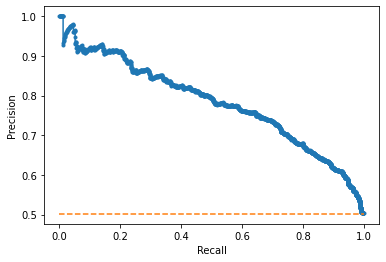

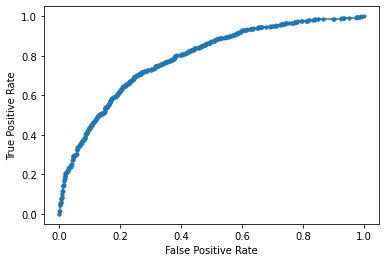

Accuracy: 68.70% Precision: 63.79% Recall: 86.98%
F1: 73.60% AUPRC: 78.33% AUROC: 78.82%
2023-02-06 14:27:55.991841

Completed cross validation 5 folds 3 epochs
 accuracy mean 69.99% +/- 1.43
 precision mean 71.21% +/- 5.17
 recall mean 73.13% +/- 11.00
 F1 mean 71.31% +/- 3.32
 AUPRC mean 79.15% +/- 2.28
 AUROC mean 78.84% +/- 0.94
Finished cell Line 11 SK.N.SH

2023-02-06 14:27:57.391981
Start cell Line 12 GM12878
Number of RCI values loaded 1698
Num RCI: 1698
Load sequence...
Cross validation...
2023-02-06 14:28:12.451809
splitting
Fold 1
Model params (mean -0.13, wgt 0.47) (mean -1.37, wgt 0.53)
RCI threshold derived from training set: [-0.79104278]
FIT
2023-02-06 14:28:15.855585
Epoch 1/3
246/246 [==============================] - 4s 14ms/step - loss: 0.6875 - accuracy: 0.5474 - val_loss: 0.7102 - val_accuracy: 0.5673
Epoch 2/3
246/246 [==============================] - 3s 12ms/step - loss: 0.6034 - accuracy: 0.6749 - val_loss: 0.5546 - val_accuracy: 0.7044
Epoch 3/3
246/246 [====

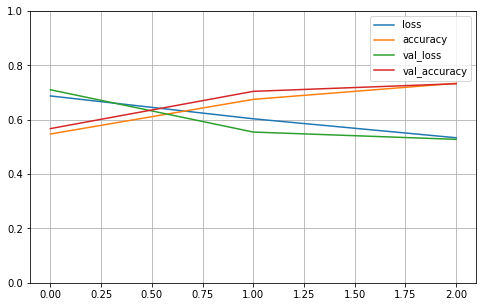

Train set ones/size 3953 / 7844
Compute valiation accuracy
Valid sizes (1962, 4997) (1962,)
Valid set ones/size 1024 / 1962
Range of scores: 0.019404585 to 0.99822026
Score threshold 0.5
Prediction set ones/size 1189 / 1962


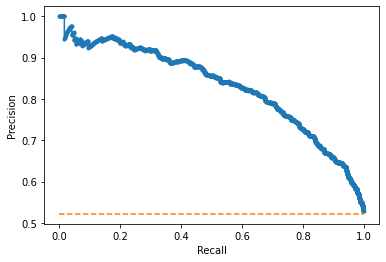

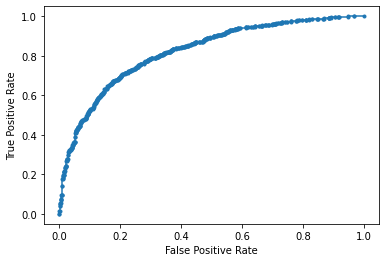

Accuracy: 73.24% Precision: 70.98% Recall: 82.42%
F1: 76.28% AUPRC: 83.12% AUROC: 82.19%
2023-02-06 14:28:26.898330
Fold 2
Model params (mean -0.21, wgt 0.49) (mean -1.33, wgt 0.51)
RCI threshold derived from training set: [-0.78580019]
FIT
2023-02-06 14:28:31.693797
Epoch 1/3
246/246 [==============================] - 4s 14ms/step - loss: 0.6924 - accuracy: 0.5409 - val_loss: 0.6501 - val_accuracy: 0.6073
Epoch 2/3
246/246 [==============================] - 3s 12ms/step - loss: 0.6066 - accuracy: 0.6637 - val_loss: 0.5616 - val_accuracy: 0.7007
Epoch 3/3
246/246 [==============================] - 3s 12ms/step - loss: 0.5410 - accuracy: 0.7219 - val_loss: 0.5117 - val_accuracy: 0.7460
PREDICT
2023-02-06 14:28:42.626403


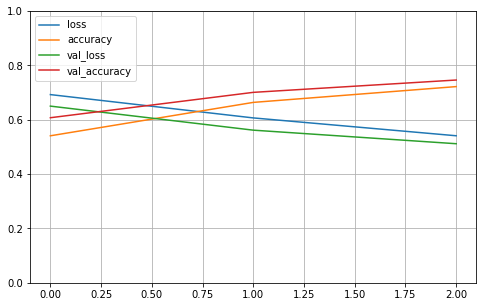

Train set ones/size 3983 / 7845
Compute valiation accuracy
Valid sizes (1961, 4997) (1961,)
Valid set ones/size 990 / 1961
Range of scores: 0.013445682 to 0.9938193
Score threshold 0.5
Prediction set ones/size 980 / 1961


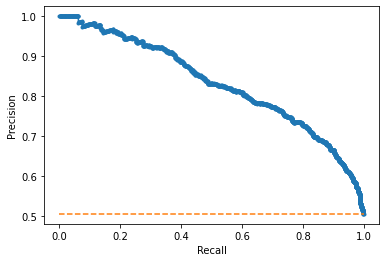

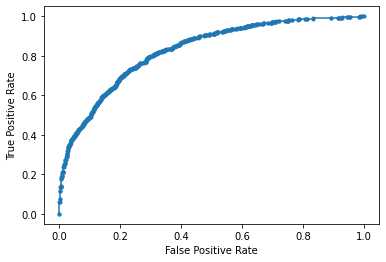

Accuracy: 74.60% Precision: 75.10% Recall: 74.34%
F1: 74.72% AUPRC: 83.23% AUROC: 82.72%
2023-02-06 14:28:43.459212
Fold 3
Model params (mean -0.18, wgt 0.48) (mean -1.35, wgt 0.52)
RCI threshold derived from training set: [-0.79087305]
FIT
2023-02-06 14:28:48.175068
Epoch 1/3
246/246 [==============================] - 4s 13ms/step - loss: 0.6970 - accuracy: 0.5324 - val_loss: 0.7203 - val_accuracy: 0.5074
Epoch 2/3
246/246 [==============================] - 3s 13ms/step - loss: 0.6135 - accuracy: 0.6595 - val_loss: 0.6007 - val_accuracy: 0.6731
Epoch 3/3
246/246 [==============================] - 3s 13ms/step - loss: 0.5176 - accuracy: 0.7442 - val_loss: 0.5309 - val_accuracy: 0.7338
PREDICT
2023-02-06 14:28:58.390393


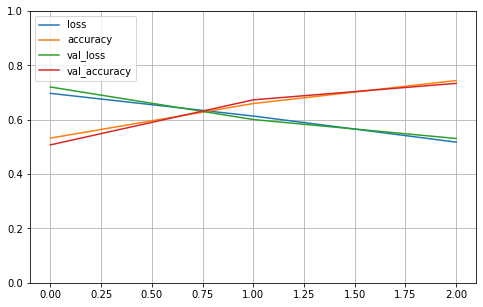

Train set ones/size 3963 / 7845
Compute valiation accuracy
Valid sizes (1961, 4997) (1961,)
Valid set ones/size 1014 / 1961
Range of scores: 0.003996784 to 0.9975043
Score threshold 0.5
Prediction set ones/size 876 / 1961


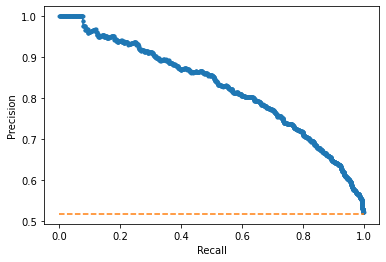

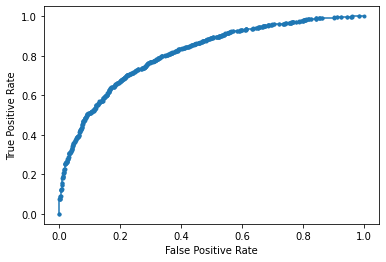

Accuracy: 73.38% Precision: 78.08% Recall: 67.46%
F1: 72.38% AUPRC: 82.64% AUROC: 81.33%
2023-02-06 14:28:59.140253
Fold 4
Model params (mean -0.18, wgt 0.48) (mean -1.32, wgt 0.52)
RCI threshold derived from training set: [-0.76738217]
FIT
2023-02-06 14:29:03.541846
Epoch 1/3
246/246 [==============================] - 4s 13ms/step - loss: 0.6975 - accuracy: 0.5216 - val_loss: 0.6799 - val_accuracy: 0.5451
Epoch 2/3
246/246 [==============================] - 3s 13ms/step - loss: 0.6166 - accuracy: 0.6575 - val_loss: 0.5701 - val_accuracy: 0.6945
Epoch 3/3
246/246 [==============================] - 3s 12ms/step - loss: 0.5402 - accuracy: 0.7336 - val_loss: 0.6366 - val_accuracy: 0.6594
PREDICT
2023-02-06 14:29:14.487623


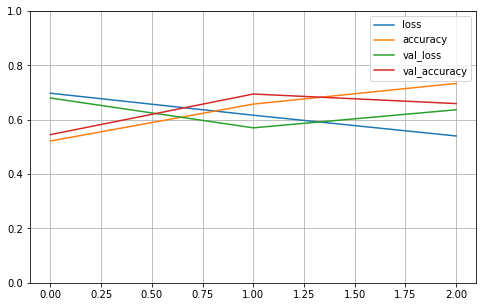

Train set ones/size 4003 / 7845
Compute valiation accuracy
Valid sizes (1961, 4997) (1961,)
Valid set ones/size 936 / 1961
Range of scores: 0.015159548 to 0.9974778
Score threshold 0.5
Prediction set ones/size 1426 / 1961


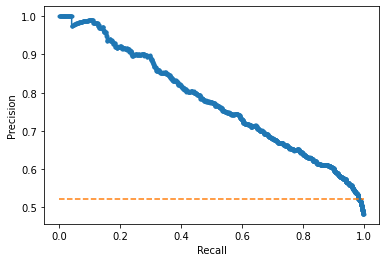

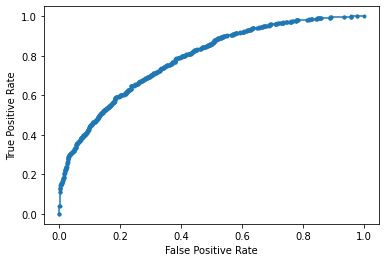

Accuracy: 65.94% Precision: 59.40% Recall: 90.49%
F1: 71.72% AUPRC: 77.86% AUROC: 78.58%
2023-02-06 14:29:15.243182
Fold 5
Model params (mean -0.19, wgt 0.48) (mean -1.36, wgt 0.52)
RCI threshold derived from training set: [-0.79529928]
FIT
2023-02-06 14:29:19.863557
Epoch 1/3
246/246 [==============================] - 4s 13ms/step - loss: 0.6923 - accuracy: 0.5453 - val_loss: 0.6418 - val_accuracy: 0.6272
Epoch 2/3
246/246 [==============================] - 3s 13ms/step - loss: 0.5982 - accuracy: 0.6818 - val_loss: 0.6274 - val_accuracy: 0.6543
Epoch 3/3
246/246 [==============================] - 3s 12ms/step - loss: 0.5224 - accuracy: 0.7407 - val_loss: 0.5019 - val_accuracy: 0.7506
PREDICT
2023-02-06 14:29:29.903869


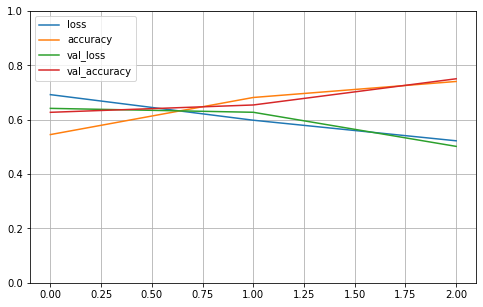

Train set ones/size 3981 / 7845
Compute valiation accuracy
Valid sizes (1961, 4997) (1961,)
Valid set ones/size 1014 / 1961
Range of scores: 0.015066668 to 0.9958528
Score threshold 0.5
Prediction set ones/size 1093 / 1961


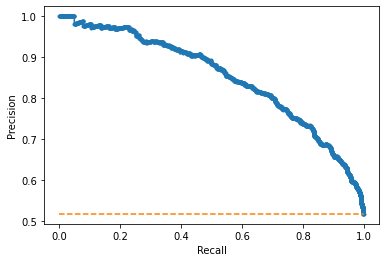

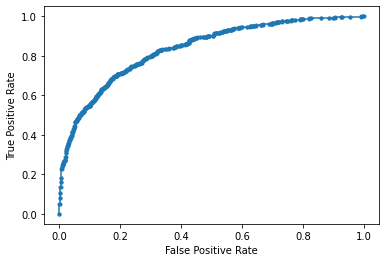

Accuracy: 75.06% Precision: 74.02% Recall: 79.78%
F1: 76.79% AUPRC: 85.14% AUROC: 83.62%
2023-02-06 14:29:30.748500

Completed cross validation 5 folds 3 epochs
 accuracy mean 72.45% +/- 3.33
 precision mean 71.52% +/- 6.47
 recall mean 78.90% +/- 7.74
 F1 mean 74.38% +/- 2.03
 AUPRC mean 82.40% +/- 2.43
 AUROC mean 81.69% +/- 1.72
Finished cell Line 12 GM12878

2023-02-06 14:29:32.157907
Start cell Line 13 K562
Number of RCI values loaded 958
Num RCI: 958
Load sequence...
Cross validation...
2023-02-06 14:29:40.431001
splitting
Fold 1
Model params (mean -1.86, wgt 0.37) (mean 0.03, wgt 0.63)
RCI threshold derived from training set: [-0.666079]
FIT
2023-02-06 14:29:42.564199
Epoch 1/3
158/158 [==============================] - 3s 15ms/step - loss: 0.6935 - accuracy: 0.5403 - val_loss: 0.6836 - val_accuracy: 0.5445
Epoch 2/3
158/158 [==============================] - 2s 13ms/step - loss: 0.6475 - accuracy: 0.6096 - val_loss: 0.5916 - val_accuracy: 0.6614
Epoch 3/3
158/158 [=============

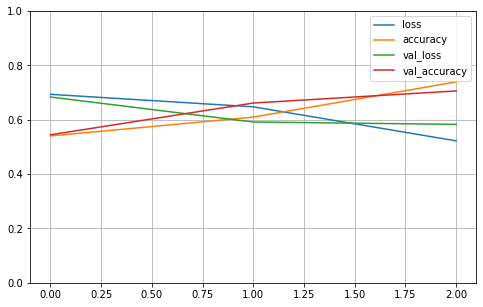

Train set ones/size 2832 / 5031
Compute valiation accuracy
Valid sizes (1258, 4997) (1258,)
Valid set ones/size 685 / 1258
Range of scores: 0.0032472906 to 0.99727374
Score threshold 0.5
Prediction set ones/size 887 / 1258


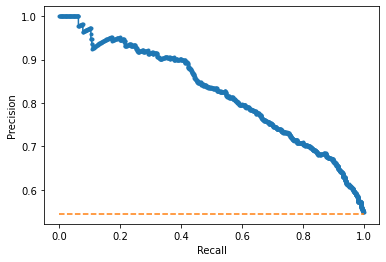

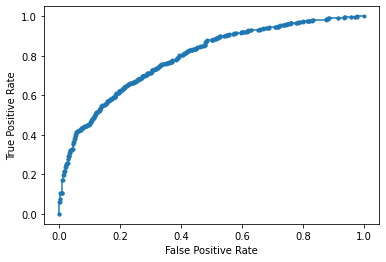

Accuracy: 70.59% Precision: 67.76% Recall: 87.74%
F1: 76.46% AUPRC: 82.49% AUROC: 79.33%
2023-02-06 14:29:54.336057
Fold 2
Model params (mean -1.88, wgt 0.37) (mean 0.00, wgt 0.63)
RCI threshold derived from training set: [-0.68970156]
FIT
2023-02-06 14:29:57.563599
Epoch 1/3
158/158 [==============================] - 3s 15ms/step - loss: 0.6951 - accuracy: 0.5355 - val_loss: 0.6690 - val_accuracy: 0.5668
Epoch 2/3
158/158 [==============================] - 2s 12ms/step - loss: 0.6338 - accuracy: 0.6394 - val_loss: 0.5745 - val_accuracy: 0.7003
Epoch 3/3
158/158 [==============================] - 2s 13ms/step - loss: 0.5289 - accuracy: 0.7350 - val_loss: 0.6320 - val_accuracy: 0.6733
PREDICT
2023-02-06 14:30:04.701281


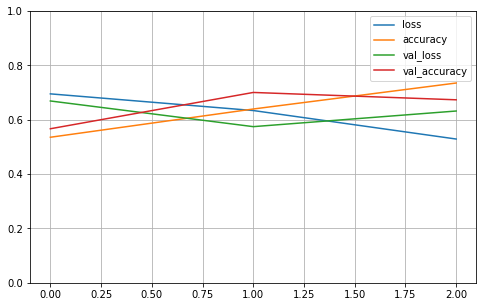

Train set ones/size 2842 / 5031
Compute valiation accuracy
Valid sizes (1258, 4997) (1258,)
Valid set ones/size 722 / 1258
Range of scores: 0.027505841 to 0.9990138
Score threshold 0.5
Prediction set ones/size 1069 / 1258


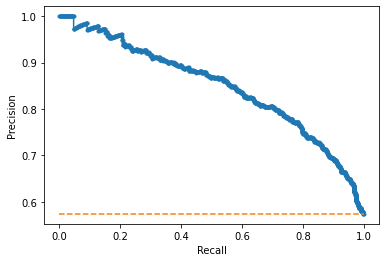

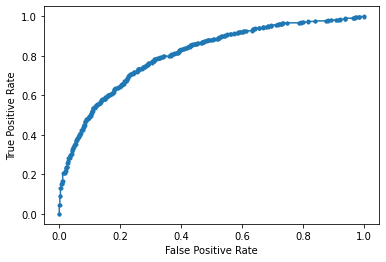

Accuracy: 67.33% Precision: 64.55% Recall: 95.57%
F1: 77.05% AUPRC: 84.86% AUROC: 80.58%
2023-02-06 14:30:05.541017
Fold 3
Model params (mean 0.02, wgt 0.63) (mean -1.86, wgt 0.37)
RCI threshold derived from training set: [-0.66607948]
FIT
2023-02-06 14:30:08.734241
Epoch 1/3
158/158 [==============================] - 3s 15ms/step - loss: 0.6968 - accuracy: 0.5359 - val_loss: 0.6679 - val_accuracy: 0.5596
Epoch 2/3
158/158 [==============================] - 2s 13ms/step - loss: 0.6413 - accuracy: 0.6261 - val_loss: 0.5785 - val_accuracy: 0.6900
Epoch 3/3
158/158 [==============================] - 2s 13ms/step - loss: 0.5406 - accuracy: 0.7299 - val_loss: 0.5428 - val_accuracy: 0.7138
PREDICT
2023-02-06 14:30:15.858144


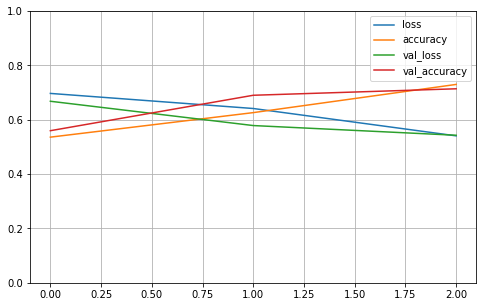

Train set ones/size 2814 / 5031
Compute valiation accuracy
Valid sizes (1258, 4997) (1258,)
Valid set ones/size 703 / 1258
Range of scores: 0.017839964 to 0.99465734
Score threshold 0.5
Prediction set ones/size 951 / 1258


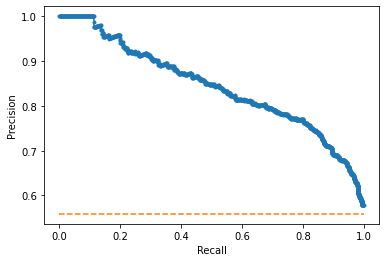

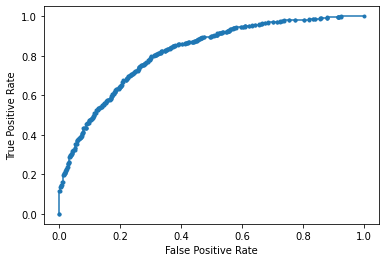

Accuracy: 71.38% Precision: 68.03% Recall: 92.03%
F1: 78.23% AUPRC: 84.39% AUROC: 81.60%
2023-02-06 14:30:16.560700
Fold 4
Model params (mean 0.01, wgt 0.63) (mean -1.89, wgt 0.37)
RCI threshold derived from training set: [-0.68100039]
FIT
2023-02-06 14:30:19.926877
Epoch 1/3
158/158 [==============================] - 3s 14ms/step - loss: 0.6977 - accuracy: 0.5474 - val_loss: 0.6833 - val_accuracy: 0.5684
Epoch 2/3
158/158 [==============================] - 2s 13ms/step - loss: 0.6652 - accuracy: 0.5880 - val_loss: 0.6290 - val_accuracy: 0.6463
Epoch 3/3
158/158 [==============================] - 2s 12ms/step - loss: 0.5670 - accuracy: 0.7056 - val_loss: 0.5318 - val_accuracy: 0.7313
PREDICT
2023-02-06 14:30:26.777018


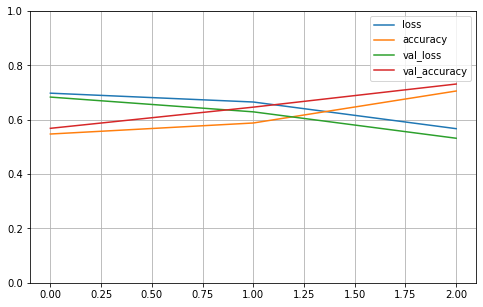

Train set ones/size 2847 / 5031
Compute valiation accuracy
Valid sizes (1258, 4997) (1258,)
Valid set ones/size 715 / 1258
Range of scores: 0.010167153 to 0.9774874
Score threshold 0.5
Prediction set ones/size 865 / 1258


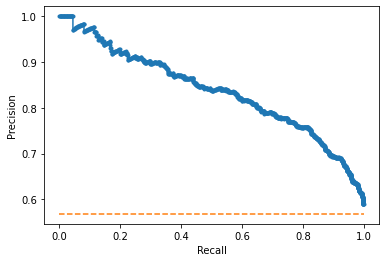

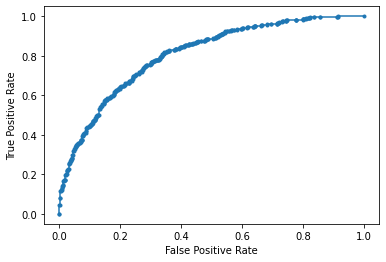

Accuracy: 73.13% Precision: 71.79% Recall: 86.85%
F1: 78.61% AUPRC: 83.75% AUROC: 80.65%
2023-02-06 14:30:27.624489
Fold 5
Model params (mean 0.01, wgt 0.64) (mean -1.91, wgt 0.36)
RCI threshold derived from training set: [-0.68573983]
FIT
2023-02-06 14:30:31.007865
Epoch 1/3
158/158 [==============================] - 3s 14ms/step - loss: 0.6842 - accuracy: 0.5548 - val_loss: 0.6746 - val_accuracy: 0.5609
Epoch 2/3
158/158 [==============================] - 2s 12ms/step - loss: 0.6216 - accuracy: 0.6502 - val_loss: 0.5849 - val_accuracy: 0.6691
Epoch 3/3
158/158 [==============================] - 2s 12ms/step - loss: 0.5351 - accuracy: 0.7343 - val_loss: 0.5375 - val_accuracy: 0.7224
PREDICT
2023-02-06 14:30:41.887361


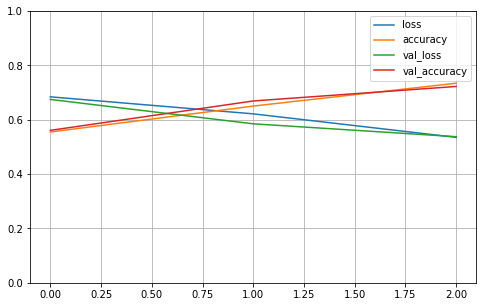

Train set ones/size 2846 / 5032
Compute valiation accuracy
Valid sizes (1257, 4997) (1257,)
Valid set ones/size 716 / 1257
Range of scores: 0.01638733 to 0.9923987
Score threshold 0.5
Prediction set ones/size 649 / 1257


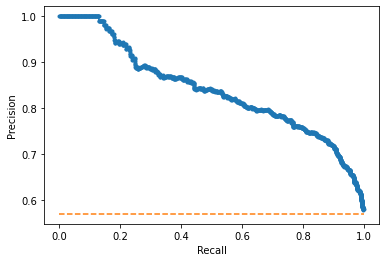

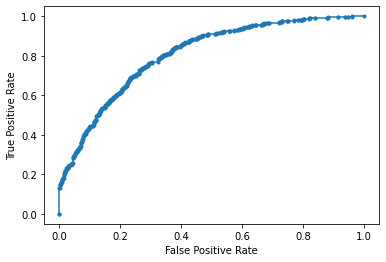

Accuracy: 72.24% Precision: 78.27% Recall: 70.95%
F1: 74.43% AUPRC: 84.01% AUROC: 80.64%
2023-02-06 14:30:42.587328

Completed cross validation 5 folds 3 epochs
 accuracy mean 70.93% +/- 1.99
 precision mean 70.08% +/- 4.70
 recall mean 86.63% +/- 8.44
 F1 mean 76.96% +/- 1.48
 AUPRC mean 83.90% +/- 0.80
 AUROC mean 80.56% +/- 0.72
Finished cell Line 13 K562

2023-02-06 14:30:43.899317
Start cell Line 14 IMR.90
Number of RCI values loaded 390
Num RCI: 390
Load sequence...
Cross validation...
2023-02-06 14:30:47.272781
splitting
Fold 1
Model params (mean 0.04, wgt 0.71) (mean -2.77, wgt 0.29)
RCI threshold derived from training set: [-0.78200989]
FIT
2023-02-06 14:30:48.082162
Epoch 1/3
62/62 [==============================] - 2s 17ms/step - loss: 0.7057 - accuracy: 0.5251 - val_loss: 0.6822 - val_accuracy: 0.5344
Epoch 2/3
62/62 [==============================] - 1s 12ms/step - loss: 0.6582 - accuracy: 0.5955 - val_loss: 0.6480 - val_accuracy: 0.6012
Epoch 3/3
62/62 [==================

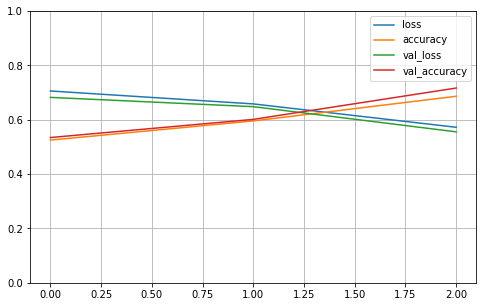

Train set ones/size 974 / 1973
Compute valiation accuracy
Valid sizes (494, 4997) (494,)
Valid set ones/size 230 / 494
Range of scores: 0.01845753 to 0.95023996
Score threshold 0.5
Prediction set ones/size 310 / 494


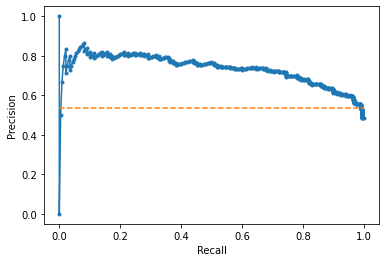

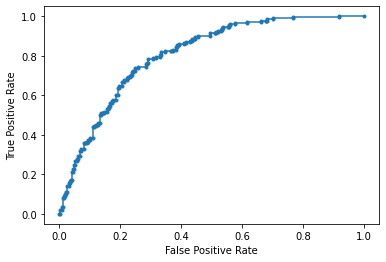

Accuracy: 71.66% Precision: 64.52% Recall: 86.96%
F1: 74.07% AUPRC: 73.41% AUROC: 80.64%
2023-02-06 14:30:51.934176
Fold 2
Model params (mean -0.31, wgt 0.89) (mean -4.93, wgt 0.11)
RCI threshold derived from training set: [-0.80434908]
FIT
2023-02-06 14:30:53.877936
Epoch 1/3
62/62 [==============================] - 2s 16ms/step - loss: 0.7194 - accuracy: 0.5124 - val_loss: 0.7043 - val_accuracy: 0.5101
Epoch 2/3
62/62 [==============================] - 1s 12ms/step - loss: 0.6835 - accuracy: 0.5443 - val_loss: 0.6815 - val_accuracy: 0.5466
Epoch 3/3
62/62 [==============================] - 1s 13ms/step - loss: 0.6273 - accuracy: 0.6457 - val_loss: 0.6136 - val_accuracy: 0.6700
PREDICT
2023-02-06 14:30:59.578360


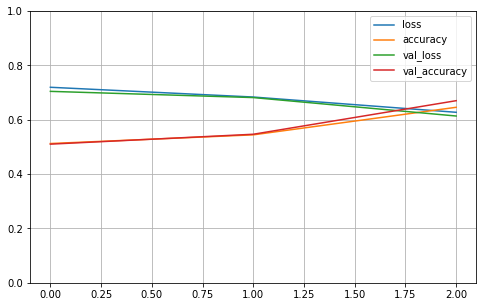

Train set ones/size 963 / 1973
Compute valiation accuracy
Valid sizes (494, 4997) (494,)
Valid set ones/size 242 / 494
Range of scores: 0.061339453 to 0.9468925
Score threshold 0.5
Prediction set ones/size 359 / 494


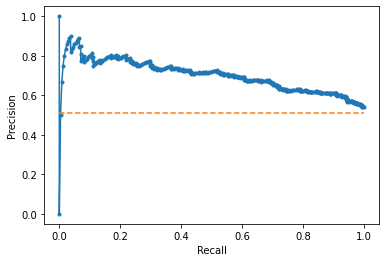

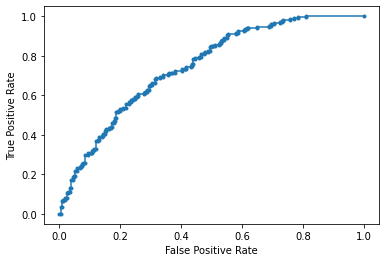

Accuracy: 67.00% Precision: 61.00% Recall: 90.50%
F1: 72.88% AUPRC: 70.09% AUROC: 74.67%
2023-02-06 14:31:00.166613
Fold 3
Model params (mean 0.06, wgt 0.69) (mean -2.68, wgt 0.31)
RCI threshold derived from training set: [-0.78396884]
FIT
2023-02-06 14:31:02.143494
Epoch 1/3
62/62 [==============================] - 2s 16ms/step - loss: 0.7235 - accuracy: 0.5132 - val_loss: 0.6833 - val_accuracy: 0.5963
Epoch 2/3
62/62 [==============================] - 1s 14ms/step - loss: 0.6511 - accuracy: 0.6403 - val_loss: 0.6202 - val_accuracy: 0.6734
Epoch 3/3
62/62 [==============================] - 1s 13ms/step - loss: 0.5564 - accuracy: 0.7264 - val_loss: 0.5128 - val_accuracy: 0.7160
PREDICT
2023-02-06 14:31:07.898357


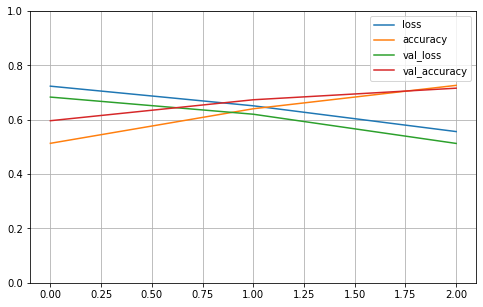

Train set ones/size 971 / 1974
Compute valiation accuracy
Valid sizes (493, 4997) (493,)
Valid set ones/size 233 / 493
Range of scores: 0.016114611 to 0.98321885
Score threshold 0.5
Prediction set ones/size 225 / 493


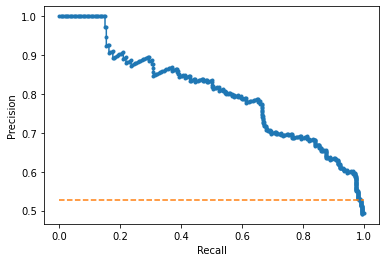

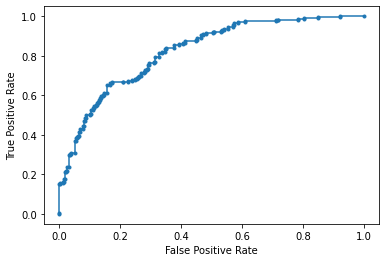

Accuracy: 71.60% Precision: 70.67% Recall: 68.24%
F1: 69.43% AUPRC: 80.52% AUROC: 82.36%
2023-02-06 14:31:08.554019
Fold 4
Model params (mean -2.69, wgt 0.31) (mean 0.06, wgt 0.69)
RCI threshold derived from training set: [-0.80439898]
FIT
2023-02-06 14:31:10.499502
Epoch 1/3
62/62 [==============================] - 2s 16ms/step - loss: 0.7047 - accuracy: 0.5299 - val_loss: 0.6856 - val_accuracy: 0.5700
Epoch 2/3
62/62 [==============================] - 1s 14ms/step - loss: 0.6748 - accuracy: 0.5709 - val_loss: 0.6718 - val_accuracy: 0.6105
Epoch 3/3
62/62 [==============================] - 1s 12ms/step - loss: 0.5962 - accuracy: 0.6910 - val_loss: 0.5999 - val_accuracy: 0.6653
PREDICT
2023-02-06 14:31:16.191393


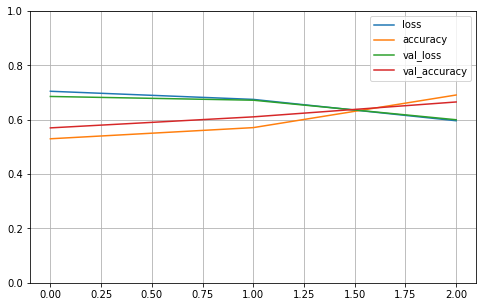

Train set ones/size 956 / 1974
Compute valiation accuracy
Valid sizes (493, 4997) (493,)
Valid set ones/size 249 / 493
Range of scores: 0.010301808 to 0.95237106
Score threshold 0.5
Prediction set ones/size 180 / 493


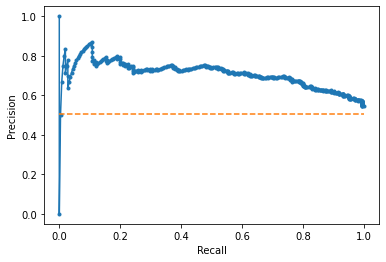

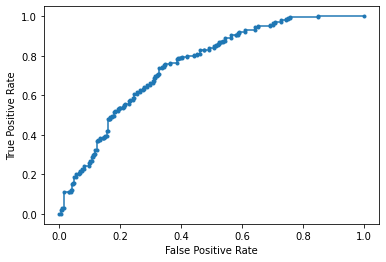

Accuracy: 66.53% Precision: 73.33% Recall: 53.01%
F1: 61.54% AUPRC: 70.74% AUROC: 75.25%
2023-02-06 14:31:16.799682
Fold 5
Model params (mean 0.01, wgt 0.69) (mean -2.75, wgt 0.31)
RCI threshold derived from training set: [-0.83840555]
FIT
2023-02-06 14:31:18.756114
Epoch 1/3
62/62 [==============================] - 2s 18ms/step - loss: 0.7013 - accuracy: 0.5562 - val_loss: 0.6631 - val_accuracy: 0.6045
Epoch 2/3
62/62 [==============================] - 1s 14ms/step - loss: 0.6551 - accuracy: 0.6201 - val_loss: 0.6088 - val_accuracy: 0.6288
Epoch 3/3
62/62 [==============================] - 1s 13ms/step - loss: 0.5650 - accuracy: 0.7305 - val_loss: 0.5096 - val_accuracy: 0.7586
PREDICT
2023-02-06 14:31:22.171600


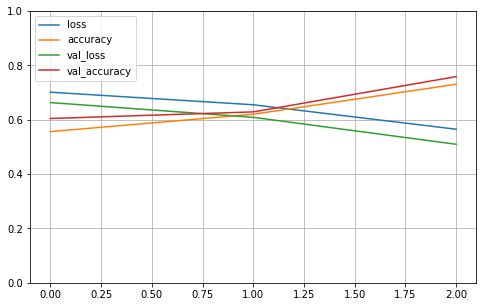

Train set ones/size 1163 / 1974
Compute valiation accuracy
Valid sizes (493, 4997) (493,)
Valid set ones/size 305 / 493
Range of scores: 0.024753164 to 0.9466775
Score threshold 0.5
Prediction set ones/size 294 / 493


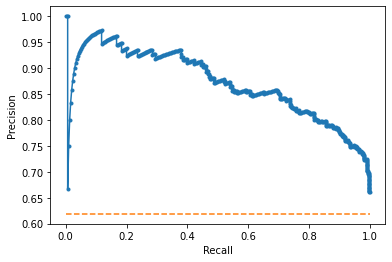

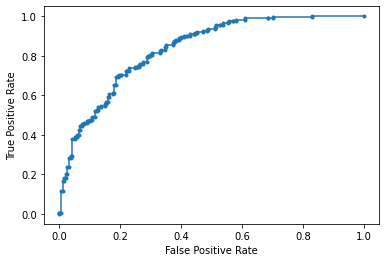

Accuracy: 75.86% Precision: 81.63% Recall: 78.69%
F1: 80.13% AUPRC: 87.12% AUROC: 83.51%
2023-02-06 14:31:22.791169

Completed cross validation 5 folds 3 epochs
 accuracy mean 70.53% +/- 3.44
 precision mean 70.23% +/- 7.18
 recall mean 75.48% +/- 13.60
 F1 mean 71.61% +/- 6.11
 AUPRC mean 76.38% +/- 6.52
 AUROC mean 79.29% +/- 3.65
Finished cell Line 14 IMR.90

2023-02-06 14:31:24.018851


In [10]:
for CELL_LINE in range(15):
    print(datetime.now())
    print('Start cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE
    gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_FILE
    allids,allseq = loader.load_sequence(filepath)
    loader = None  # drop K-mer cache to save RAM

    print("Cross validation...")
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc = cvdo.do_cross_validation()   
    cvdo = None
    print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
    print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
    print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
    print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
    print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
    print(" AUPRC mean %.2f%% +/- %.2f" % (np.mean(cv_auprc), np.std(cv_auprc)))
    print(" AUROC mean %.2f%% +/- %.2f" % (np.mean(cv_auroc), np.std(cv_auroc)))
    print('Finished cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    print()
print(datetime.now())